<a href="https://colab.research.google.com/github/shabnamsattar/Human-Data-Analysis/blob/main/chestMNIST/chestMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import os
import random
import time
import pickle
import zipfile
import logging
import requests
import psutil
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import ImageFont
from tqdm import tqdm
from skimage.measure import label
from math import ceil
from tqdm.auto import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

import holoviews as hv
from holoviews import opts

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, Input, Conv2D, BatchNormalization, Dense, ReLU, concatenate, Lambda
from tensorflow.keras.models import load_model, clone_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Necessary Functions

## Uploading Data

In [ ]:
dataset_paths = {
    64 : '/content/drive/MyDrive/chestMNIST/chestmnist_64.npz',
    128 : '/content/drive/MyDrive/chestMNIST/chestmnist_128.npz',
    224 : '/content/drive/MyDrive/chestMNIST/chestmnist_224.npz',
    }

def load_dataset(size):

    if size not in dataset_paths:
        raise ValueError(f"Dataset version {size} not found. Available: {list(dataset_paths.keys())}")
    data = np.load(dataset_paths[size], mmap_mode="r")

    train_images = data["train_images"]
    train_labels = data["train_labels"]
    val_images =   data["val_images"]
    val_labels =   data["val_labels"]
    test_images =  data["test_images"]
    test_labels =  data["test_labels"]

    return train_images ,train_labels ,val_images ,val_labels ,test_images ,test_labels

## Data Preprocessing

### Sub-sampling

In [ ]:
def subsample(imgs, labels, pct=0.05, seed= None):
    """Randomly subsample a percentage of a dataset."""
    n_samples = imgs.shape[0]
    n_select = int(n_samples * pct)
    rng = np.random.default_rng(seed)
    indices = rng.choice(n_samples, size=n_select, replace=False)
    return imgs[indices], labels[indices]

### Generators

In [ ]:
IMAGENET_GRAY_MEAN  = 0.485        # ImageNet luminance mean in [0‒1] scale
def subtract_imagenet_mean(x):
    return x - IMAGENET_GRAY_MEAN

In [ ]:
def get_datagen(augmentation=True):
    if augmentation:
        return ImageDataGenerator(
            rescale=1./255.,      # bring raw pixels to [0,1]
            rotation_range=10,    # ±10°
            horizontal_flip=True,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.05,
            preprocessing_function=subtract_imagenet_mean     # subtract ImageNet mean
        )
    else:
        return ImageDataGenerator(
            rescale=1./255.,
            preprocessing_function=subtract_imagenet_mean
        )

In [ ]:
def get_datagen(augmentation=True):
    if augmentation:
        return ImageDataGenerator(
            rescale=1./255.,      # bring raw pixels to [0,1]
            rotation_range=10,    # ±10°
            horizontal_flip=True,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.05,
            featurewise_std_normalization=True    # subtract ImageNet mean
        )
    else:
        return ImageDataGenerator(
            rescale=1./255.,
            featurewise_std_normalization=True
        )

In [ ]:
def data_generator_1(images, labels, batch_size, augmentation=True, seed=None):
    gen = get_datagen(augmentation)
    rng = np.random.default_rng(seed)            # deterministic RNG

    while True:
        idxs = np.arange(len(images))
        for start in range(0, len(images), batch_size):
            end   = min(start + batch_size, len(images))
            batch = idxs[start:end]

            x = images[batch]
            y = labels[batch]

            if x.ndim == 3:
                x = np.expand_dims(x, -1)

            # seed every individual transform
            x_aug = np.stack(
                [gen.random_transform(img, seed=int(rng.integers(1e9)))
                 for img in x]
            )
            yield x_aug, y


In [ ]:
def data_generator_2(images, labels, batch_size):

    while True:
        idxs = np.arange(len(images))
        for start in range(0, len(images), batch_size):
            end   = min(start + batch_size, len(images))
            batch = idxs[start:end]

            x = images[batch]
            y = labels[batch]

            if x.ndim == 3:
                x = np.expand_dims(x, -1)

            yield np.array(x), np.array(y)

In [ ]:
def data_generator_3(global_images, local_images, labels, batch_size, datagen=None):
    while True:
        idxs = np.arange(len(labels))
        for start in range(0, len(labels), batch_size):
            end = min(start + batch_size, len(labels))
            batch_indices = idxs[start:end]

            g = global_images[batch_indices]
            l = local_images[batch_indices]
            y = labels[batch_indices]

            # Add channel dimension for grayscale images
            g = np.expand_dims(g, axis=-1)
            l = np.expand_dims(l, axis=-1)

            # Apply augmentation if provided
            if datagen:
                g = np.array([datagen.random_transform(img) for img in g])
                l = np.array([datagen.random_transform(img) for img in l])

            yield (g, l), y

In [ ]:
#in version aslie simple data generator hast age balae ok bud badan ino hazf kon

def data_generator_2(images, labels, batch_size):
    while True:
        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_images = images[start:end]
            batch_labels = labels[start:end]

            # Add a channel dimension for each image
            batch_images = [np.expand_dims(img, axis=-1) for img in batch_images]

            yield np.array(batch_images), np.array(batch_labels)

## HEATMAPS

In [ ]:
def generate_heatmaps(image, model, last_cnn_layer_name, dense_layer_name):
    # Get the last CNN layer output and Dense layer weights
    cnn_layer = model.get_layer(last_cnn_layer_name).output  # Shape: (None, 7, 7, 512)
    dense_layer = model.get_layer(dense_layer_name)
    dense_weights = dense_layer.get_weights()[0]  # Shape: (512, 14)

    # Create a model to extract features
    feature_extractor = Model(inputs=model.input, outputs=cnn_layer)
    feature_maps = feature_extractor.predict(image, verbose=0)  # Shape: (1, 7, 7, 512)

    # Compute heatmaps
    heatmaps = np.dot(feature_maps[0], dense_weights)  # Shape: (7, 7, 14)
    return heatmaps

In [ ]:
def generate_heatmaps_batch(images, model, last_cnn_layer_name, dense_layer_name):

    # Get the last CNN layer output and Dense layer weights
    cnn_layer = model.get_layer(last_cnn_layer_name).output  # Shape: (None, height, width, filters)
    dense_layer = model.get_layer(dense_layer_name)
    dense_weights = dense_layer.get_weights()[0]  # Shape: (filters, num_classes)

    # Create a model to extract features
    feature_extractor = Model(inputs=model.input, outputs=cnn_layer)

    # Extract feature maps for the entire batch
    feature_maps = feature_extractor.predict(images, verbose=0)  # Shape: (batch_size, height, width, filters)

    # Compute heatmaps by matrix multiplication for each image in the batch
    heatmaps = np.tensordot(feature_maps, dense_weights, axes=([3], [0]))  # Shape: (batch_size, height, width, num_classes)

    return heatmaps


In [ ]:
def heatmap_to_mask(hm, thresh=0.5):
    """
    hm: 2-D heat-map already resized to the image resolution and
        normalised to [0,1].
    thresh: scalar or tuple.  If float – binary mask hm>=thresh.
            If (lo, hi) – two-level mask like the paper:
            keep pixels where lo<=hm<hi.
    """
    if isinstance(thresh, tuple):
        lo, hi = thresh
        mask = (hm >= lo) & (hm < hi)
    else:
        mask = hm >= thresh
    return mask.astype(np.uint8)         # 0/1

def mask_to_bbox(mask, margin=2):
    "Returns xmin, ymin, xmax, ymax (inclusive).  Empty mask → None."
    ys, xs = np.where(mask)
    if len(xs) == 0:
        return None
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()

    # Optional safety margin so nothing important is clipped
    xmin = max(0, xmin - margin); ymin = max(0, ymin - margin)
    xmax = min(mask.shape[1] - 1, xmax + margin)
    ymax = min(mask.shape[0] - 1, ymax + margin)
    return xmin, ymin, xmax, ymax

def crop_and_resize(img, bbox, target_sz=(64, 64)):
    "Crop bbox from img, then resize to the input size expected by local CNN."
    xmin, ymin, xmax, ymax = bbox
    crop = img[ymin:ymax+1, xmin:xmax+1]
    return cv2.resize(crop, target_sz, interpolation=cv2.INTER_LINEAR)


# Models

In [ ]:
def run_experiment(loss, batch_size, num_epochs, model,
                   train_generator, val_generator,
                   model_base, initial_lr = 0.01):                 # pass *base* path, no ext
    # ---------- compile ----------
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate= initial_lr),
        loss=loss,
        metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
                 tf.keras.metrics.AUC(name="auc")]
    )

    steps_per_epoch  = math.ceil(len(train_images_64) / batch_size)
    validation_steps = math.ceil(len(val_images_64)   / batch_size)

    # ---------- callbacks ----------
    callbacks = [
        # 1) stop training if val-AUC hasn’t improved for 6 epochs
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc', mode='max',
            start_from_epoch=20,
            patience=6, restore_best_weights=True, verbose=1),


        # 2) one-line CSV of the metrics after every epoch
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch, lr: initial_lr * 0.1 ** (epoch // 20),  # ↓10× every 20 epochs
            verbose=1)
    ]

    # ---------- train ----------
    t0 = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,                 # ← new line
        verbose=1
    )
    print(f"Training took {time.time() - t0:.1f}s")

    # ---------- save final model & history ----------
    model_file   = f'{model_base}.keras'
    history_file = f'{model_base}_history.pkl'
    os.makedirs(os.path.dirname(model_file), exist_ok=True)

    model.save(model_file)
    pickle.dump(history.history, open(history_file, 'wb'))

    # ---------- memory usage ----------
    mem_mb = psutil.Process().memory_info().rss / 1_048_576
    print(f"Current memory usage: {mem_mb:.2f} MB")

    print("saved:", model_file)
    print("saved:", history_file)
    return model, history


## 5layers_CNN

In [ ]:
def CNN5layers(input_shape, num_classes=14, l2_weight=1e-4, dropout_rate=0.25):

    """
    Parameters
    ----------
    input_shape : tuple  (H, W, C)
        Works for 64×64, 128×128, 224×224, etc.
    num_classes : int
        Number of disease labels (ChestMNIST = 14).
    l2_weight   : float
        L2 weight decay applied to Conv kernels.
    dropout_rate: float
        Dropout after each pooling layer.

    """
    weight_decay = regularizers.l2(l2_weight)
    inputs = layers.Input(shape=input_shape)

    # ----- Block 1 -----
    x = layers.Conv2D(32, (3, 3), padding="same",
                      kernel_regularizer=weight_decay)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate)(x)

    # ----- Block 2 -----
    x = layers.Conv2D(64, (3, 3), padding="same",
                      kernel_regularizer=weight_decay)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate)(x)

    # ----- Block 3 -----
    x = layers.Conv2D(128, (3, 3), padding="same",
                      kernel_regularizer=weight_decay)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate)(x)

    # ----- Block 4 -----
    x = layers.Conv2D(256, (3, 3), padding="same",
                      kernel_regularizer=weight_decay)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate)(x)

    # ----- Block 5 (no extra pooling, keep features rich) -----
    x = layers.Conv2D(256, (3, 3), padding="same",
                      kernel_regularizer=weight_decay)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Global pooling makes the network resolution-agnostic
    x = layers.GlobalAveragePooling2D()(x)

    # Final dense → 14 logits → sigmoid for multi-label probs
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    return model


## RESNET_18, 34, 50

In [ ]:
# -----------------------------------------------------------------------------
#  ResNet building blocks
# -----------------------------------------------------------------------------


L2 = 1e-4      # weight-decay – tweak if you like

def conv_bn_relu(x, filters, k=3, s=1):
    """Conv → BN → ReLU helper"""
    x = layers.Conv2D(filters, k, strides=s, padding="same",
                      use_bias=False, kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def residual_block(x, filters, downsample, bottleneck=False):
    """
    BasicBlock (ResNet-18/34) … OR … Bottleneck (ResNet-50)
    `downsample` = True halves H,W and (optionally) doubles filters.
    """
    shortcut = x

    if bottleneck:            # -------- Bottleneck variant (1×1–3×3–1×1)
        f1, f2, f3 = filters//4, filters//4, filters
        x = conv_bn_relu(x, f1, k=1, s=1 if not downsample else 2)
        x = conv_bn_relu(x, f2, k=3, s=1)
        x = layers.Conv2D(f3, 1, padding="same", use_bias=False,
                          kernel_regularizer=regularizers.l2(L2))(x)
        x = layers.BatchNormalization()(x)
    else:                     # -------- BasicBlock variant (3×3–3×3)
        x = conv_bn_relu(x, filters, 3, s=1 if not downsample else 2)
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                          kernel_regularizer=regularizers.l2(L2))(x)
        x = layers.BatchNormalization()(x)

    # ----- match shortcut dims if needed
    if downsample or shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(filters, 1, strides=2 if downsample else 1,
                                 padding="same", use_bias=False,
                                 kernel_regularizer=regularizers.l2(L2))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    return layers.ReLU()(x)

def make_stage(x, filters, n_blocks, bottleneck=False):
    """Stack `n_blocks` residual blocks; first one may downsample."""
    x = residual_block(x, filters, downsample=True,  bottleneck=bottleneck)
    for _ in range(1, n_blocks):
        x = residual_block(x, filters, downsample=False, bottleneck=bottleneck)
    return x

# -----------------------------------------------------------------------------
#  Factory
# -----------------------------------------------------------------------------
def ResNet(input_shape, n_classes=14, variant = "18"):
    """
    variant ∈ {"18", "34", "50"}
    Returns an un-compiled tf.keras.Model
    """
    assert variant in {"18", "34", "50"}, "variant must be 18, 34 or 50"

    block_cfg = {           # blocks per stage (Conv2_x … Conv5_x)
        "18": [2, 2, 2, 2],
        "34": [3, 4, 6, 3],
        "50": [3, 4, 6, 3],
    }[variant]
    bottleneck = variant == "50"

    inputs = layers.Input(shape=input_shape)

    # -------- stem (no max-pool: helps small 64–128 px inputs)
    x = conv_bn_relu(inputs, 64, k=7, s=2)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # -------- stages
    filters = 64
    for nb in block_cfg:
        x = make_stage(x, filters, nb, bottleneck=bottleneck)
        filters *= 2        # double filters after each stage

    # -------- head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)

    return Model(inputs, outputs, name=f"ResNet{variant}_{input_shape[0]}")


## DENSENET_121

In [ ]:
# ------------------------------------------------------------------
#  Helper blocks
# ------------------------------------------------------------------
def conv_block(x, growth_rate, name):
    """Bottleneck + 3×3 conv as in the paper."""
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.ReLU(name=f"{name}_relu1")(x)
    x = layers.Conv2D(4 * growth_rate,              # 1×1 “bottleneck”
                      kernel_size=1, use_bias=False,
                      kernel_initializer="he_normal",
                      name=f"{name}_conv1")(x)

    x = layers.BatchNormalization(name=f"{name}_bn2")(x)
    x = layers.ReLU(name=f"{name}_relu2")(x)
    x = layers.Conv2D(growth_rate,                  # 3×3 conv
                      kernel_size=3, padding="same", use_bias=False,
                      kernel_initializer="he_normal",
                      name=f"{name}_conv2")(x)
    return x


def dense_block(x, n_layers, growth_rate, name):
    """Stack `n_layers` conv_blocks with feature-map concatenation."""
    for i in range(n_layers):
        cb = conv_block(x, growth_rate, name=f"{name}_cb{i + 1}")
        x  = layers.Concatenate(axis=-1, name=f"{name}_concat{i + 1}")([x, cb])
    return x


def transition_block(x, reduction, name):
    """1×1 conv + 2×2 average-pooling to compress and down-sample."""
    x = layers.BatchNormalization(name=f"{name}_bn")(x)
    x = layers.ReLU(name=f"{name}_relu")(x)
    x = layers.Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction),
                      kernel_size=1, use_bias=False,
                      kernel_initializer="he_normal",
                      name=f"{name}_conv")(x)
    x = layers.AvgPool2D(pool_size=2, strides=2, name=f"{name}_pool")(x)
    return x

# ------------------------------------------------------------------
#  DenseNet-121
# ------------------------------------------------------------------
def DenseNet121(input_shape=(224, 224, 1),
                      num_classes=14,
                      growth_rate=32,
                      reduction=0.5,
                      weight_decay=1e-4,
                      final_activation="sigmoid"):
    """
    Returns a Keras Model that matches the DenseNet-121 topology.

    Args
    ----
    input_shape      : 3-tuple, e.g. (224, 224, 1) for chestMNIST.
    num_classes      : Number of output labels (14 for chestMNIST).
    growth_rate      : `k` in the paper (default 32).
    reduction        : θ in transition layers (default 0.5).
    weight_decay     : L2 regularisation factor for all Conv kernels.
    final_activation : 'sigmoid' for multi-label classification.
    """
    wd = regularizers.l2(weight_decay)
    img_input = layers.Input(shape=input_shape, name="input")

    # -------- initial stem --------
    x = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False,
                      kernel_initializer="he_normal", kernel_regularizer=wd,
                      name="stem_conv")(img_input)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same", name="stem_pool")(x)

    # -------- dense blocks + transitions --------
    x = dense_block(x,  6, growth_rate, name="dense1")          #  6 layers
    x = transition_block(x, reduction, name="trans1")

    x = dense_block(x, 12, growth_rate, name="dense2")          # 12 layers
    x = transition_block(x, reduction, name="trans2")

    x = dense_block(x, 24, growth_rate, name="dense3")          # 24 layers
    x = transition_block(x, reduction, name="trans3")

    x = dense_block(x, 16, growth_rate, name="dense4")          # 16 layers

    # -------- classification head --------
    x = layers.BatchNormalization(name="bn_final")(x)
    x = layers.ReLU(name="relu_final")(x)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    output = layers.Dense(num_classes, activation=final_activation,
                          name="predictions")(x)

    model = models.Model(img_input, output, name="DenseNet121")

    return model


# Evaluations & Visualization

### Accuracy, AUC, Loss plots

In [ ]:
def plot_training_history(
    history,
    metrics=None,
    smoothing_window: int = 2,
    show_raw: bool = False,
    figsize=(14, 4),
    sharey: bool = False,

):

    # Allow passing either a History object or plain dict
    hist_dict = history.history if hasattr(history, "history") else history

    def moving_average(arr, win):
        if win <= 1:
            return np.asarray(arr)
        return np.convolve(arr, np.ones(win) / win, mode="valid")

    # Determine which metric names to use
    if metrics is None:
        base_metrics = [
            k for k in hist_dict.keys() if not k.startswith("val_") and f"val_{k}" in hist_dict
        ]
    else:
        base_metrics = [m for m in metrics if f"val_{m}" in hist_dict]

    if not base_metrics:
        raise ValueError("No matching train/validation metric pairs were found.")

    n_cols = 2
    n_rows = ceil(len(base_metrics) / n_cols)


    plt.style.use("default")
    mpl.rcParams.update({
          "axes.prop_cycle": mpl.cycler(color=["#66a61e", "#6a3d9a",
                                         "#66a61e", "#6a3d9a"]),
          "lines.linewidth": 2,
    })

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows), sharey=sharey
    )
    axes = np.atleast_1d(axes).flatten()  # Handles 1-subplot case

    for ax, metric in zip(axes, base_metrics):
        train_vals = hist_dict[metric]
        val_vals = hist_dict[f"val_{metric}"]

        # Raw curves (optional)
        if show_raw:
            ax.plot(train_vals, label="Train", alpha=0.3,linewidth= 2, linestyle="--")
            ax.plot(val_vals, label="Validation", alpha=0.3, linewidth= 2, linestyle="--")

        # Smoothed curves
        train_smoothed = moving_average(train_vals, smoothing_window)
        val_smoothed = moving_average(val_vals, smoothing_window)

        offset = smoothing_window - 1  # Align smoothed with original epochs
        epochs = np.arange(len(train_smoothed)) + offset

        ax.plot(epochs, train_smoothed, linewidth= 2, label="Train (smoothed)")
        ax.plot(epochs, val_smoothed, linewidth= 2, label="Val (smoothed)")

        ax.set_title(metric.replace("_", " ").capitalize())
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.capitalize())
        ax.grid (alpha= 0.3)
        ax.legend(loc="best")

    # Hide any unused subplots
    for j in range(len(base_metrics), n_rows * n_cols):
        axes[j].set_visible(False)

    fig.tight_layout()
    #return fig


### Confusion Matrix

In [ ]:
def evaluate_multilabel_model(
    model,
    test_set,
    y_true,
    class_labels,
    batch_size: int = 64,
    threshold_strategy: str = "f1",
    plot_confusion: bool = True,
    font_size: int = 20,
):


    # -------------------------------------------------
    # 1. Basic evaluation
    #-------------------------------------------------

    steps = int(np.ceil(len(y_true) / batch_size))
    evaluation = model.evaluate(test_set, steps=steps, verbose=0)

    print(f"Test loss     : {evaluation[0]:.4f}")
    print(f"Test accuracy : {evaluation[1]:.4f}")
    print(f"Test AUC      : {evaluation[2]:.4f}")

    #Hold the metrics in a dict so we can return them
    metrics = {"loss": evaluation[0], "accuracy": evaluation[1], "auc": evaluation[2]}

    # -------------------------------------------------
    # 2. Predict probabilities
    # -------------------------------------------------

    y_probs = model.predict(test_set, steps=steps, verbose=0)

    #Make sure the two arrays have the **same** length
    n = min(len(y_true), len(y_probs))
    y_true  = y_true[:n]
    y_probs = y_probs[:n]

    # -------------------------------------------------
    # 3. Threshold selection
    # -------------------------------------------------

    if threshold_strategy == "f1":
        thresholds = np.zeros(len(class_labels))
        for i, label in enumerate(class_labels):
            precision, recall, th = precision_recall_curve(y_true[:, i], y_probs[:, i])
            f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
            thresholds[i] = th[np.argmax(f1)]

    else:
      thresholds = np.full(len(class_labels), float(threshold_strategy))

    # -------------------------------------------------
    # 4. Final predictions & reports
    # -------------------------------------------------

    y_pred = (y_probs > thresholds).astype(int)

    cls_report = classification_report(y_true, y_pred, target_names=class_labels,
        zero_division=0)

    print("\nClassification report\n" + "-" * 80)
    print(cls_report)

    conf_mats = multilabel_confusion_matrix(y_true, y_pred)

    # -------------------------------------------------
    # 5. Plot confusion matrices (optional)
    # -------------------------------------------------

    if plot_confusion:
        plt.rcParams.update({"font.size": font_size})
        n_labels = len(class_labels)
        n_cols = 4
        n_rows = ceil(n_labels / n_cols)

        fig, axes = plt.subplots( n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))


        axes = axes.flatten()

        for idx, (cm, label) in enumerate(zip(conf_mats, class_labels)):
            ax = axes[idx]
            im = ax.imshow(cm, cmap="Blues", interpolation="nearest")
            ax.set_title(label)
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])

            # Put numbers inside the squares
            for i in range(2):
                for j in range(2):
                    ax.text(
                        j,
                        i,
                        f"{cm[i, j]}",
                        ha="center",
                        va="center",
                        color="black",
                    )

    # Hide any unused subplots
    for idx in range(n_labels, len(axes)):
      axes[idx].remove()
    fig.tight_layout()
    plt.show()

    # -------------------------------------------------
    # 6. Return everything for programmatic use
    # -------------------------------------------------

    return {
        "metrics": metrics,
        "thresholds": thresholds,
        "classification_report": cls_report,
        "confusion_matrices": conf_mats,
    }


### ROC Curve

Roc per model

In [ ]:
def plot_multiclass_roc(
    y_true,
    y_probs,
    class_labels = CLASS_LABELS,
    model_name: str = "",
    base_cmap: str = "viridis"):

    n_classes = y_true.shape[1]

    # build colour + linestyle lists -----------------------------------------
    cmap     = cm.get_cmap(base_cmap, n_classes)
    colours  = [cmap(i) for i in range(n_classes)]
    #linestyles = ["solid" if i < n_classes/2 else "dashed"
                  #for i in range(n_classes)]
    linestyles = ["solid" for i in range(n_classes)]

    # ------------------------------------------------------------------------
    plt.figure(figsize=(9, 7))
    plt.title(model_name, fontsize=14)

    # grey reference
    plt.plot([0, 1], [0, 1], "--", color="grey", lw=2)

    # per-class curves --------------------------------------------------------
    auc_values = {}
    for i, label in enumerate(class_labels):
        try:
            fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
            auc_val = auc(fpr, tpr)
        except ValueError:          # class unusable (all 0 or 1)
            fpr, tpr, auc_val = [0, 1], [0, 1], np.nan

        auc_values[label] = auc_val

        plt.plot(
            fpr,
            tpr,
            label=f"{label}  " if np.isnan(auc_val) else f"{label}  ({auc_val:.2f})",
            color=colours[i],
            linestyle=linestyles[i],
            lw=2,
        )

    # axes, legend -----------------------------------------------------------
    plt.xlim([0, 1])
    plt.ylim([0, 1.01])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(alpha=0.3, linestyle=":")

    plt.legend(
        loc="lower right",
        fontsize=8,
        borderpad=0.4,
        frameon=True,
        framealpha=0.9,
    )
    plt.tight_layout()
    plt.show()

ROC per Class

In [ ]:
def plot_multimodel_roc(
    y_true,
    y_prob_list,
    model_names,
    class_labels = CLASS_LABELS,
    n_cols: int = 4,
    figsize: tuple = (18, 12),
    cmap_name: str = "Set1",          # any Matplotlib qualitative map
):

    assert len(y_prob_list) == len(model_names), "Mismatch models / names"
    n_classes = y_true.shape[1]
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    # colour palette – automatically sized to #models
    cmap = cm.get_cmap(cmap_name, len(model_names))
    colours = [cmap(i) for i in range(len(model_names))]

    for c_idx, label in enumerate(class_labels):
        ax = axes[c_idx]

        # grey diagonal for “random”
        ax.plot([0, 1], [0, 1], "--", color="grey", linewidth=1)

        for m_idx, (probs, m_name) in enumerate(zip(y_prob_list, model_names)):
            try:
                fpr, tpr, _ = roc_curve(y_true[:, c_idx], probs[:, c_idx])
                auc_val = auc(fpr, tpr)
            except ValueError:
                # class absent → roc_curve raises, show empty curve
                fpr, tpr, auc_val = [0, 1], [0, 1], np.nan

            ax.plot(
                fpr,
                tpr,
                label=f"{m_name} (AUC = {auc_val:.3f})",
                color=colours[m_idx],
                lw=1.8,
            )

        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(label, fontsize=11)

    # turn off any unused empty panels
    for j in range(n_classes, len(axes)):
        axes[j].set_visible(False)

    # one legend for all sub-plots – outside the grid
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="center right",
        frameon=True,
        title="Models",
    )
    fig.tight_layout(rect=[0, 0, 0.88, 1])  # leave space on right for legend
    plt.show()


# Experiments

In [ ]:
CLASS_LABELS = [
    'atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass',
    'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema',
    'emphysema', 'fibrosis', 'pleural_thickening', 'hernia'
]


##ChestMnist_64

In [ ]:
SEED = 42

In [ ]:
train_img_64, train_lbl_64, val_img_64, val_lbl_64, test_img_64, test_lbl_64 = load_dataset(64)

In [ ]:
train_images_64, train_labels_64 = subsample(train_img_64, train_lbl_64, seed=SEED)
val_images_64, val_labels_64   = subsample(val_img_64, val_lbl_64, seed=SEED)
test_images_64, test_labels_64  = subsample(test_img_64, test_lbl_64, seed=SEED)


In [ ]:
train_generator_64 = data_generator_1(train_images_64, train_labels_64, batch_size=64, augmentation=True, seed=SEED)
valid_generator_64 = data_generator_1(val_images_64, val_labels_64, batch_size=64, augmentation=False, seed=SEED)
test_generator_64 = data_generator_1(test_images_64, test_labels_64,batch_size=64, augmentation=False, seed=SEED)

### 1) 5layer_CNN

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/CNN_global_64'

CNN_global_64 , CNN_global_64_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model=CNN5layers((64, 64, 1), num_classes=14),
    train_generator=train_generator_64,
    val_generator=valid_generator_64,
    model_base=model_base
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - acc: 0.9192 - auc: 0.6661 - loss: 0.3727 - val_acc: 0.9508 - val_auc: 0.5281 - val_loss: 0.4475 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9458 - auc: 0.7547 - loss: 0.2123 - val_acc: 0.9484 - val_auc: 0.6663 - val_loss: 0.2381 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 0.9459 - auc: 0.7526 - loss: 0.2077 - val_acc: 0.9497 - val_auc: 0.7259 - val_loss: 0.2100 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.9459 - auc: 0.7540 - loss: 0.2127 - val_acc: 0.9487 - val_auc: 0.7509 - val_loss: 0.1986 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9459 

##### Evaluation

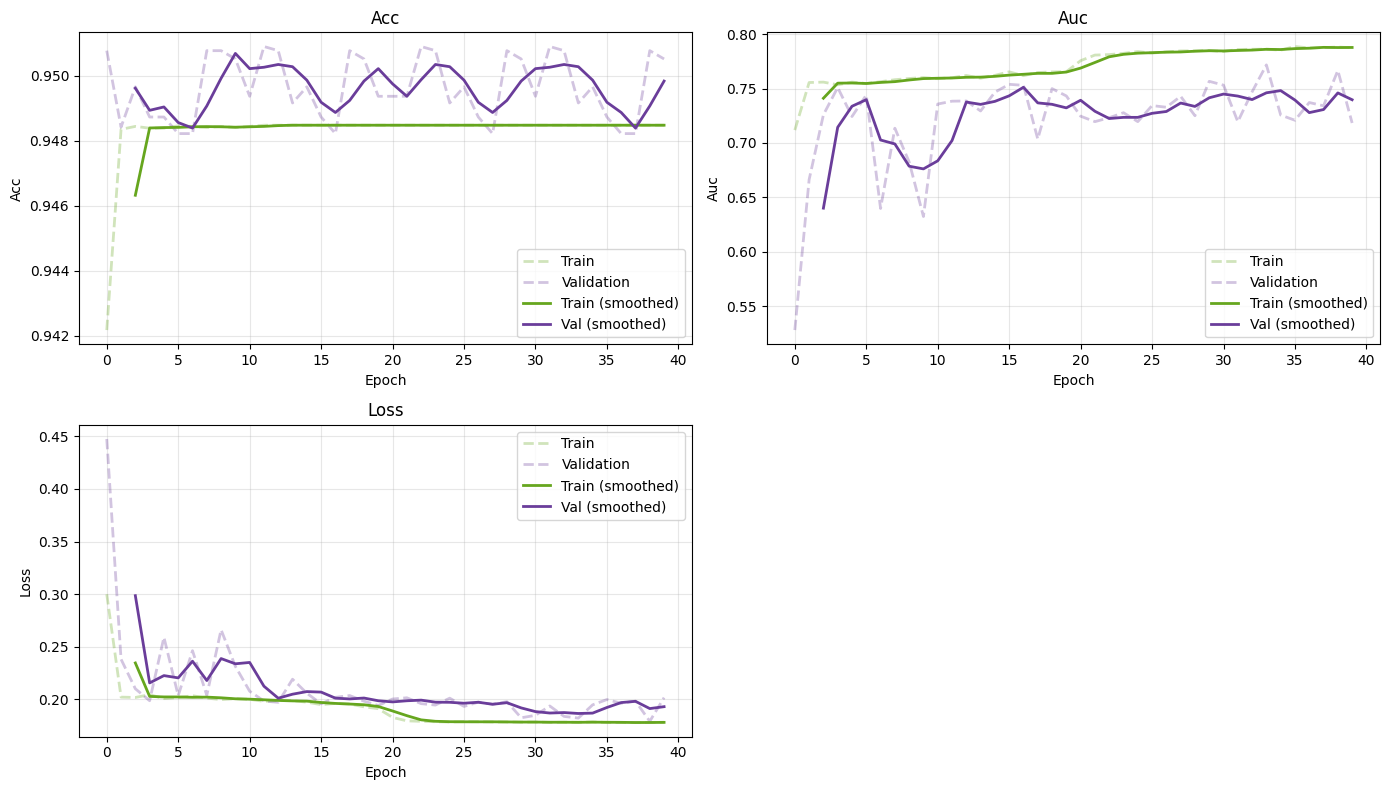

In [ ]:
plot_training_history(CNN_global_64_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_64) / 64))

In [ ]:
evaluation = CNN_global_64.evaluate(test_generator_64, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_C_G_64 = CNN_global_64.predict(test_generator_64, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_64[:, i], y_prob_C_G_64[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}


Per-class AUROC
--------------------------------------------------------------------------------
atelectasis         : 0.5521807357556541
cardiomegaly        : 0.45228621952759884
effusion            : 0.5691764340603896
infiltration        : 0.475837545550723
mass                : 0.38331937252512943
nodule              : 0.5000739120151372
pneumonia           : 0.3204087766756838
pneumothorax        : 0.49308738353059683
consolidation       : 0.5359010270774976
edema               : 0.5419863597612958
emphysema           : 0.458893163657887
fibrosis            : 0.5309954751131222
pleural_thickening  : 0.4643881208397337
hernia              : 0.5723860589812333


In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_64,
    y_probs       = y_prob_C_G_64,
    model_name    = "5layer_CNN")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/CNN_global_64.keras"
history_path = '/content/drive/MyDrive/chestMNIST/CNN_global_64_history.pkl'

CNN_global_64 = keras.models.load_model(model_path)
CNN_global_64_history = pickle.load(open(history_path, 'rb'))


#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_64 = data_generator_2(train_images_64, train_labels_64, batch_size=1)
valid_generator2_64 = data_generator_2(val_images_64, val_labels_64, batch_size=1)
test_generator2_64 = data_generator_2(test_images_64, test_labels_64, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_CNN_64.npz")

num_samples = len(train_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



Processing images:   0%|                              | 0/3923 [00:00<?, ?img/s]


Done!  Saved one epoch of masked data to:
/content/drive/MyDrive/chestMNIST/BBox/train_bbox_CNN_64.npz


In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_CNN_64.npz")

num_samples = len(val_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



Processing images:   0%|                               | 0/560 [00:00<?, ?img/s]


Done!  Saved one epoch of masked data to:
/content/drive/MyDrive/chestMNIST/BBox/val_bbox_CNN_64.npz


In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_CNN_64.npz")

num_samples = len(test_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



Processing images:   0%|                              | 0/1121 [00:00<?, ?img/s]


Done!  Saved one epoch of masked data to:
/content/drive/MyDrive/chestMNIST/BBox/test_bbox_CNN_64.npz


##### Loading BBOX Images

In [ ]:
data_1 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_CNN_64.npz')
train_img_bbox_64_cnn = data_1['images']
train_img_bbox_64_cnn = np.squeeze(train_img_bbox_64_cnn)
train_lbl_bbox_64_cnn = data_1['labels']
train_lbl_bbox_64_cnn = np.squeeze(train_lbl_bbox_64_cnn)

In [ ]:
data_2 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_CNN_64.npz')
val_img_bbox_64_cnn = data_2['images']
val_img_bbox_64_cnn = np.squeeze(val_img_bbox_64_cnn)
val_lbl_bbox_64_cnn = data_2['labels']
val_lbl_bbox_64_cnn = np.squeeze(val_lbl_bbox_64_cnn)

In [ ]:
data_3 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_CNN_64.npz')
test_img_bbox_64_cnn = data_3['images']
test_img_bbox_64_cnn = np.squeeze(test_img_bbox_64_cnn)
test_lbl_bbox_64_cnn = data_3['labels']
test_lbl_bbox_64_cnn = np.squeeze(test_lbl_bbox_64_cnn)

##### Run the model

In [ ]:
SEED = 42

In [ ]:
train_generator_64 = data_generator_1(train_img_bbox_64_cnn, train_lbl_bbox_64_cnn, batch_size=64, augmentation=True, seed=SEED)
valid_generator_64 = data_generator_1(val_img_bbox_64_cnn, val_lbl_bbox_64_cnn, batch_size=64, augmentation=False, seed=SEED)
test_generator_64 = data_generator_1(test_img_bbox_64_cnn, test_lbl_bbox_64_cnn,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/CNN_local_64'

CNN_local_64 , CNN_local_64_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model=CNN5layers((64, 64, 1), num_classes=14),
    train_generator=train_generator_64,
    val_generator=valid_generator_64,
    model_base=model_base
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - acc: 0.8933 - auc: 0.6417 - loss: 0.4079 - val_acc: 0.9508 - val_auc: 0.5863 - val_loss: 0.3488 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9456 - auc: 0.7147 - loss: 0.2259 - val_acc: 0.9492 - val_auc: 0.6456 - val_loss: 0.2483 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 0.9458 - auc: 0.7196 - loss: 0.2185 - val_acc: 0.9492 - val_auc: 0.7327 - val_loss: 0.2214 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9459 - auc: 0.7191 - loss: 0.2199 - val_acc: 0.9497 - val_auc: 0.7183 - val_loss: 0.2125 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.9458 

##### Evaluation

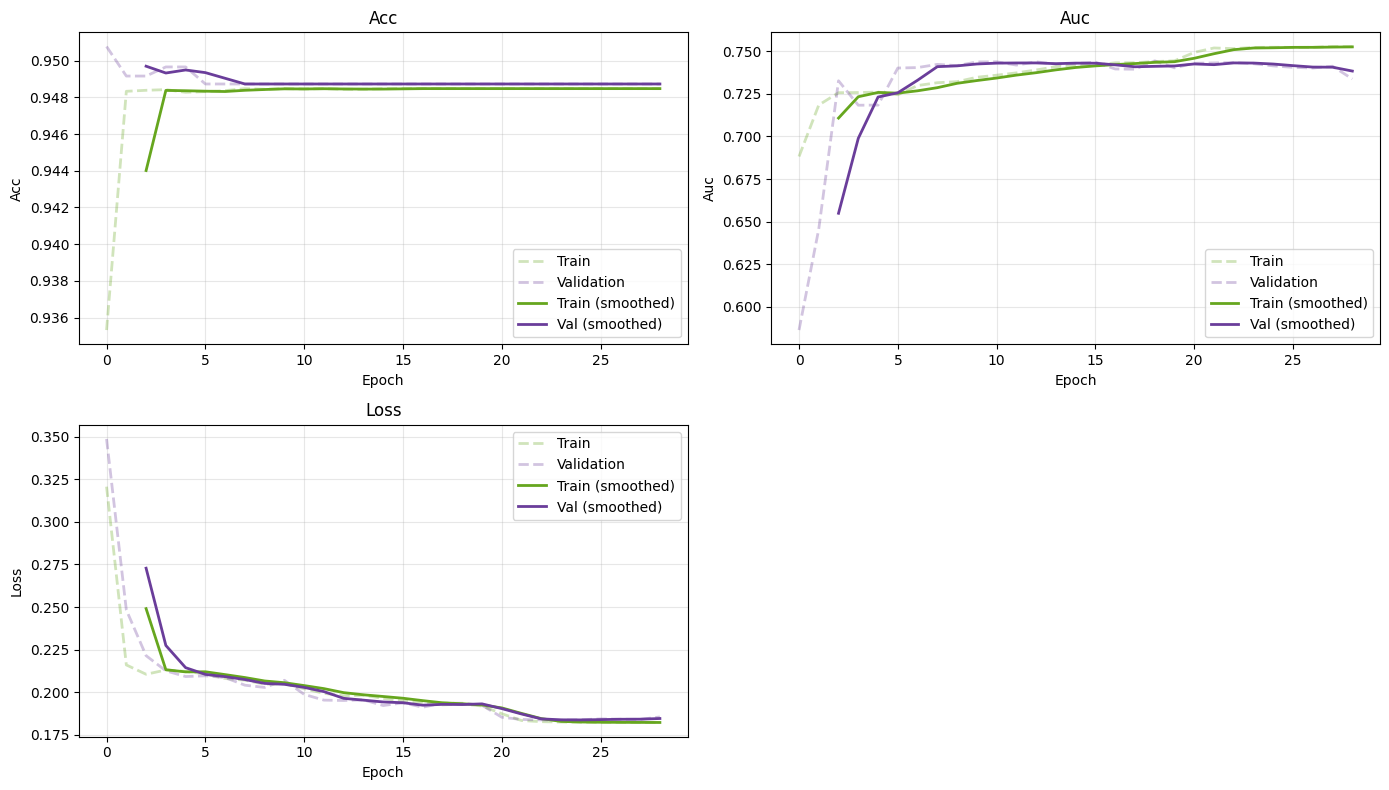

In [ ]:
plot_training_history(CNN_local_64_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_64) / 64))

In [ ]:
evaluation = CNN_local_64.evaluate(test_generator_64, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_C_l_64 = CNN_local_64.predict(test_generator_64, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_64[:, i], y_prob_C_l_64[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_64,
    y_probs       = y_prob_C_l_64,
    model_name    = "5layer_CNN")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/CNN_local_64.keras"
history_path = '/content/drive/MyDrive/chestMNIST/CNN_local_64_history.pkl'

CNN_local_64 = keras.models.load_model(model_path)
CNN_local_64_history = pickle.load(open(history_path, 'rb'))


#### 3- Fiusion Branch

In [ ]:
# ------------------------------------------------------------------
#  freeze / unfreeze helpers
# ------------------------------------------------------------------
def set_trainable(model, flag: bool = False):
    """
    Recursively (un)freeze all layers of a model.
    """
    for layer in model.layers:
        layer.trainable = flag


In [ ]:
# ------------------------------------------------------------------
#  Fusion-branch constructor
# ------------------------------------------------------------------
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Dense, Dropout, concatenate

def build_fusion_model(global_model: tf.keras.Model,
                       local_model : tf.keras.Model,
                       num_classes : int = 14,
                       hidden_units: int = 256,
                       dropout_rate: float = 0.3,
                       fine_tune_backbones: bool = False) -> tf.keras.Model:
    """
    Returns a Keras model that takes **two** inputs
      (global image, local crop)  ➜  14-label prediction.
    """
    # --- clone to keep original models untouched ---
    g_base = clone_model(global_model)
    g_base.set_weights(global_model.get_weights())

    l_base = clone_model(local_model)
    l_base.set_weights(local_model.get_weights())

    # remove last Dense (index -1). The penultimate layer is GlobalAveragePooling2D
    g_feat = g_base.layers[-2].output   # (None, 256)
    l_feat = l_base.layers[-2].output

    # Optionally lock the two back-bones
    set_trainable(g_base, fine_tune_backbones)
    set_trainable(l_base, fine_tune_backbones)

    # --- fusion head ---
    x = concatenate([g_feat, l_feat], name="concat_global_local")
    x = Dense(hidden_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation="sigmoid", name="fusion_logits")(x)

    fusion_model = Model(inputs=[g_base.input, l_base.input],
                         outputs=outputs,
                         name="FusionBranch")
    return fusion_model


In [ ]:
fusion_train_gen = data_generator_3(train_images_64,
                                    train_img_bbox_64_cnn,
                                    train_labels_64,
                                    batch_size=64,
                                    datagen=get_datagen(True))

fusion_val_gen   = data_generator_3(val_images_64,
                                    val_img_bbox_64_cnn,
                                    val_labels_64,
                                    batch_size=64,
                                    datagen=get_datagen(False))

fusion_test_gen = data_generator_3(test_images_64,
                                   test_img_bbox_64_cnn,
                                   test_labels_64,
                                   batch_size=64,
                                   datagen= False)


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [ ]:
# ------------------------------------------------------------------
#  Train & save
# ------------------------------------------------------------------
def run_fusion_experiment(loss,
                          batch_size,
                          num_epochs,
                          fusion_model,
                          train_generator,
                          val_generator,
                          model_base,
                          initial_lr = 1e-3):

    fusion_model.compile(optimizer=tf.keras.optimizers.Adam(initial_lr),
                         loss=loss,
                         metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
                                  tf.keras.metrics.AUC(name="auc")])

    steps_per_epoch  = math.ceil(len(train_labels_64)/batch_size)
    validation_steps = math.ceil(len(val_labels_64)/batch_size)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_auc",
                                         mode="max",
                                         patience=6,
                                         restore_best_weights=True,
                                         verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc",
                                             mode="max",
                                             factor=0.2,
                                             patience=3,
                                             min_lr=1e-6,
                                             verbose=1),
    ]

    history = fusion_model.fit(train_generator,
                               validation_data   = val_generator,
                               epochs            = num_epochs,
                               steps_per_epoch   = steps_per_epoch,
                               validation_steps  = validation_steps,
                               callbacks         = callbacks,
                               verbose           = 1)

    # ----- save -----
    fusion_model.save(f"{model_base}.keras")
    pickle.dump(history.history, open(f"{model_base}_history.pkl", "wb"))

    return fusion_model, history


In [ ]:
# 1) build the fusion branch
fusion_model = build_fusion_model(CNN_global_64,
                                  CNN_local_64,
                                  num_classes=14,
                                  hidden_units=256,
                                  dropout_rate=0.3,
                                  fine_tune_backbones=False)



In [ ]:
# 2) train
fusion_model, fusion_hist = run_fusion_experiment(
        loss='binary_crossentropy',
        batch_size=64,
        num_epochs=30,
        fusion_model=fusion_model,
        train_generator=fusion_train_gen,
        val_generator  =fusion_val_gen,
        model_base     ="/content/drive/MyDrive/chestMNIST/CNN_fusion_64",
        initial_lr     =1e-3)



Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - acc: 0.8924 - auc: 0.5900 - loss: 0.3379 - val_acc: 0.9508 - val_auc: 0.7632 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - acc: 0.9459 - auc: 0.7320 - loss: 0.1927 - val_acc: 0.9492 - val_auc: 0.7738 - val_loss: 0.1758 - learning_rate: 0.0010
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - acc: 0.9460 - auc: 0.7495 - loss: 0.1887 - val_acc: 0.9497 - val_auc: 0.7727 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - acc: 0.9460 - auc: 0.7616 - loss: 0.1859 - val_acc: 0.9487 - val_auc: 0.7814 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - acc: 0.9460 - auc: 0.7616 - loss: 0.1858 - val_acc: 0.9482 - val_auc: 0.7804 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - acc: 0.9459 - auc: 0.7707 - loss: 0.1833 - val_acc: 0.9508 - val_auc: 0.7809 - v

In [ ]:

fusion_test_gen = data_generator_3(test_images_64,
                                   test_img_bbox_64_cnn,
                                   test_labels_64,
                                   batch_size=64,
                                   datagen=None)



Test loss     : 0.1797
Test accuracy : 0.9479
Test AUC      : 0.7686

Classification report
--------------------------------------------------------------------------------
                    precision    recall  f1-score   support

       atelectasis       0.12      0.87      0.21       124
      cardiomegaly       0.05      0.34      0.08        29
          effusion       0.14      0.45      0.21       130
      infiltration       0.16      0.99      0.28       181
              mass       0.06      0.10      0.08        49
            nodule       0.06      0.55      0.11        64
         pneumonia       0.02      0.08      0.03        12
      pneumothorax       0.07      0.74      0.13        76
     consolidation       0.06      0.28      0.10        50
             edema       0.00      0.00      0.00        17
         emphysema       0.03      0.77      0.06        31
          fibrosis       0.02      0.56      0.05        16
pleural_thickening       0.08      0.11      0

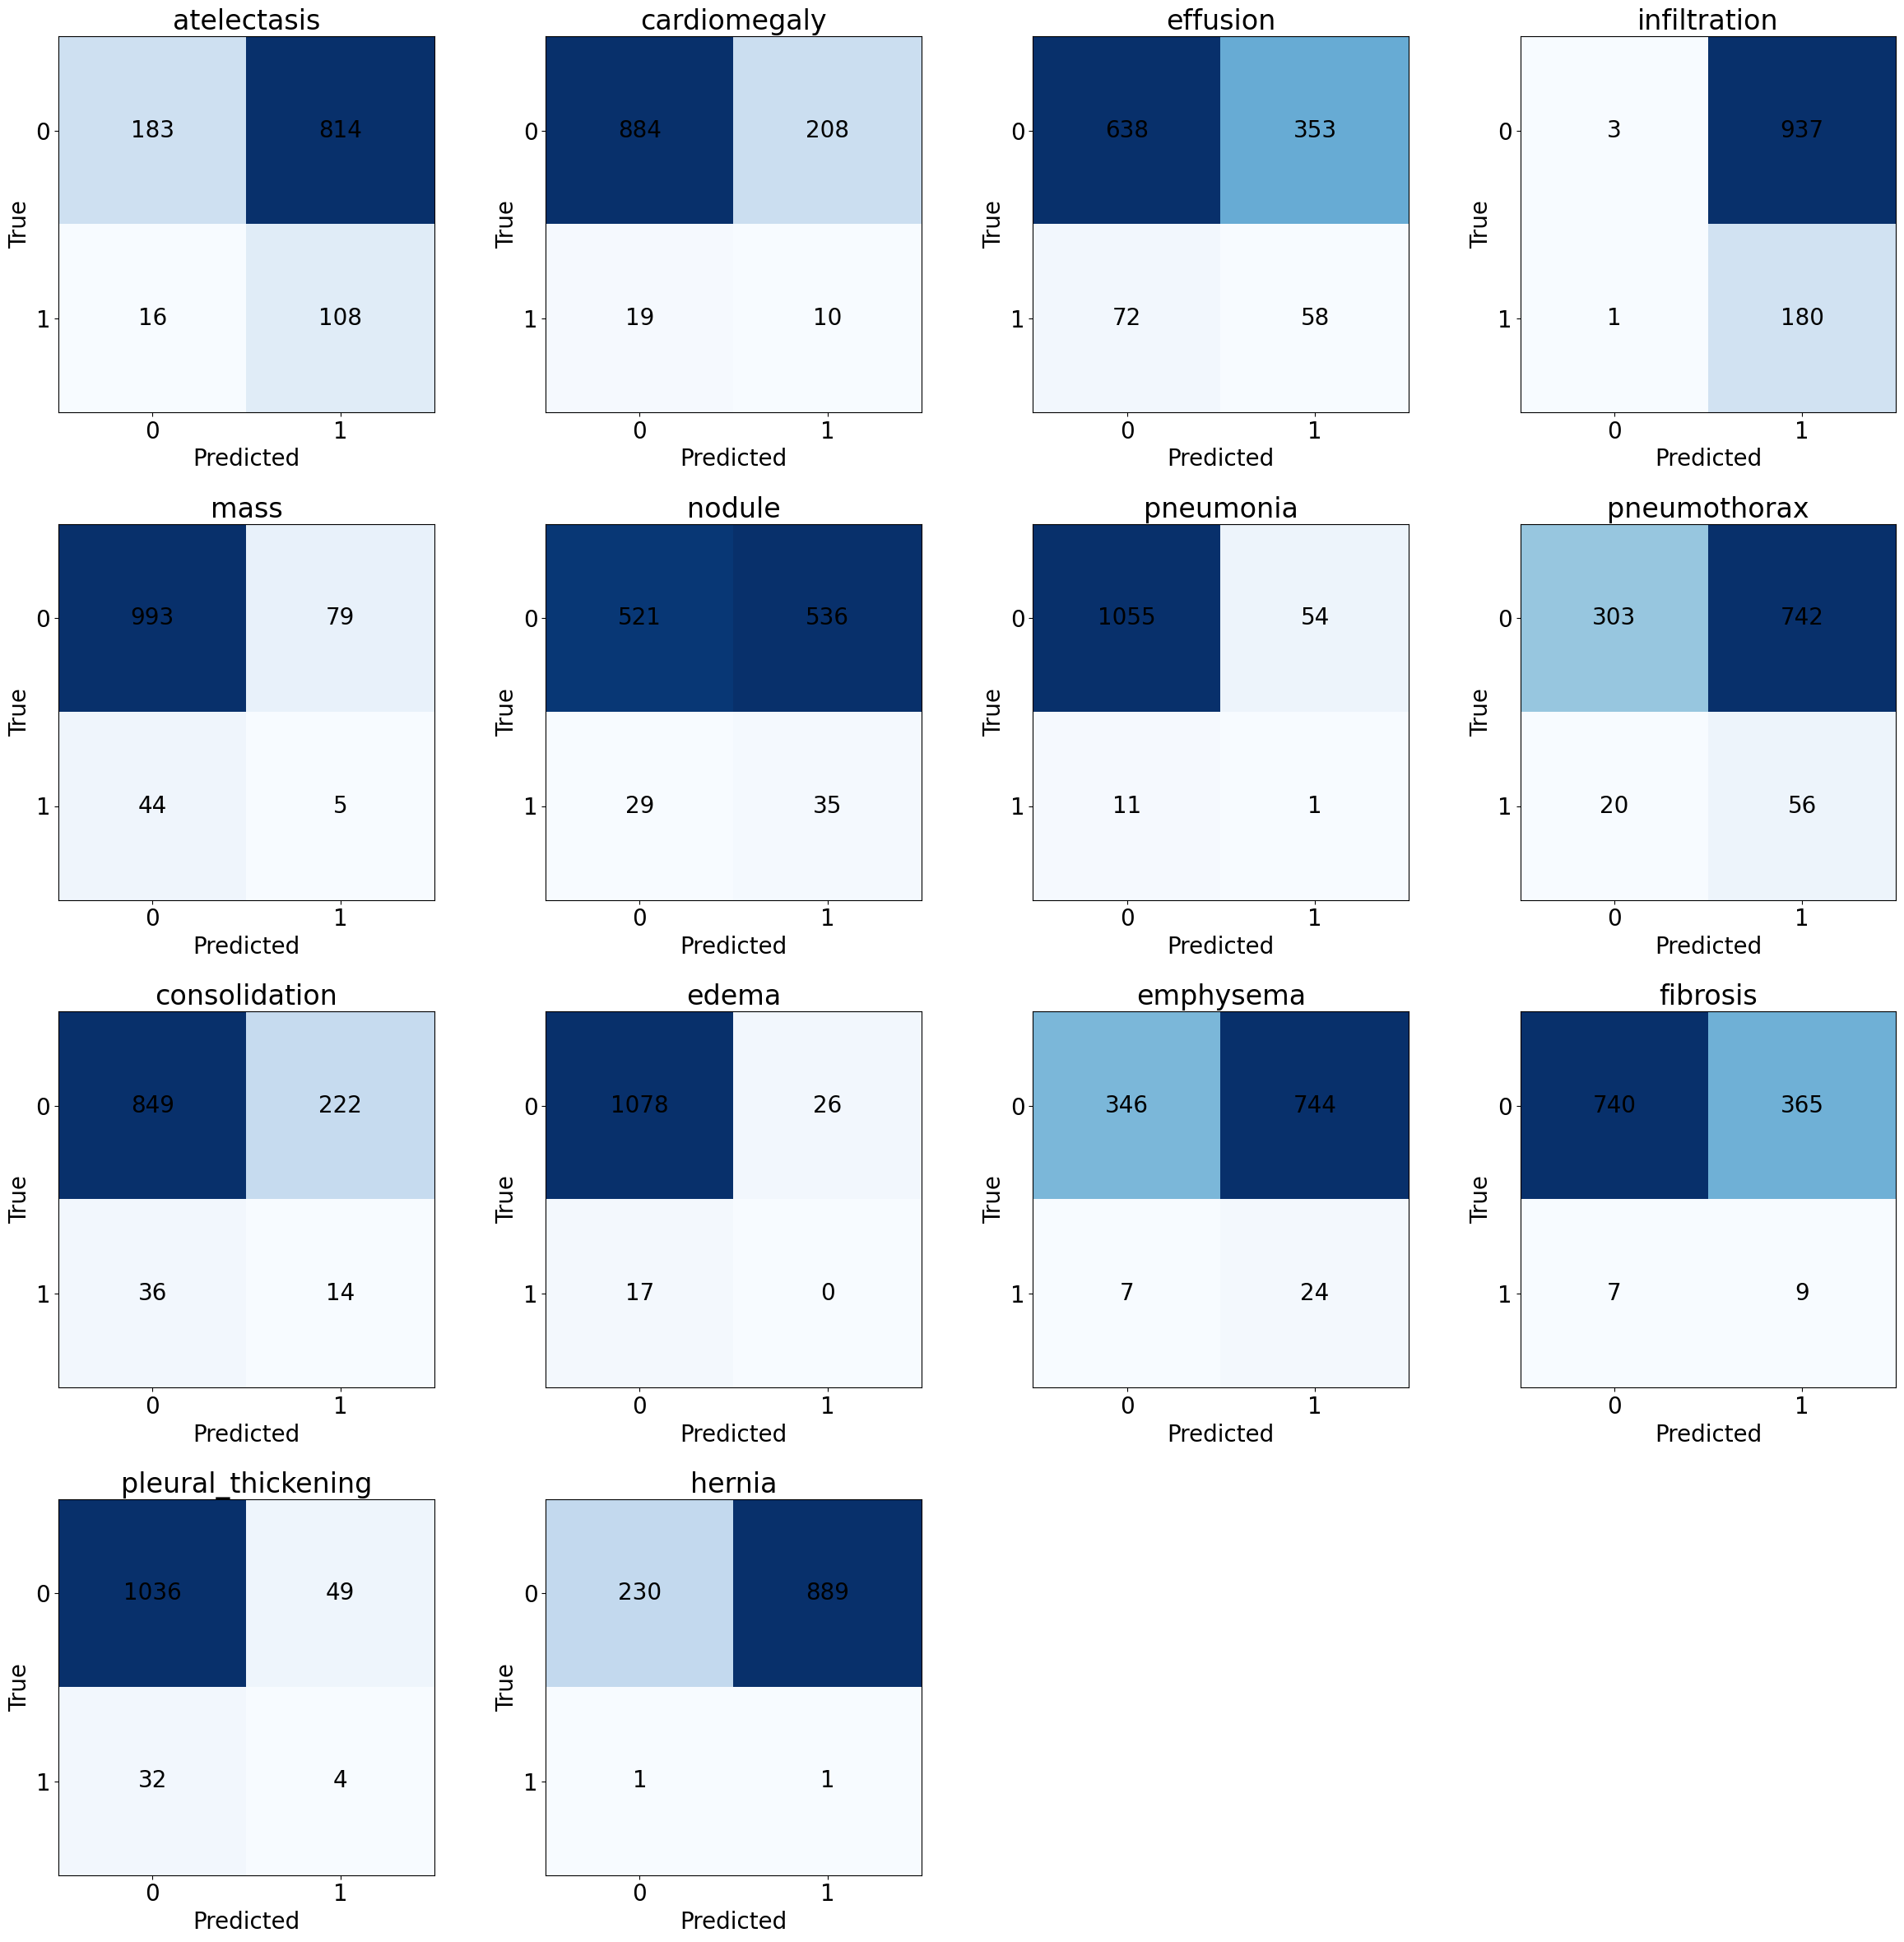

In [ ]:
results = evaluate_multilabel_model(fusion_model,
                          fusion_test_gen,
                          test_labels_64,
                          CLASS_LABELS,
                          batch_size=64,
                          threshold_strategy="f1")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<ipython-input-17-a158d5dfc710>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(class_labels))


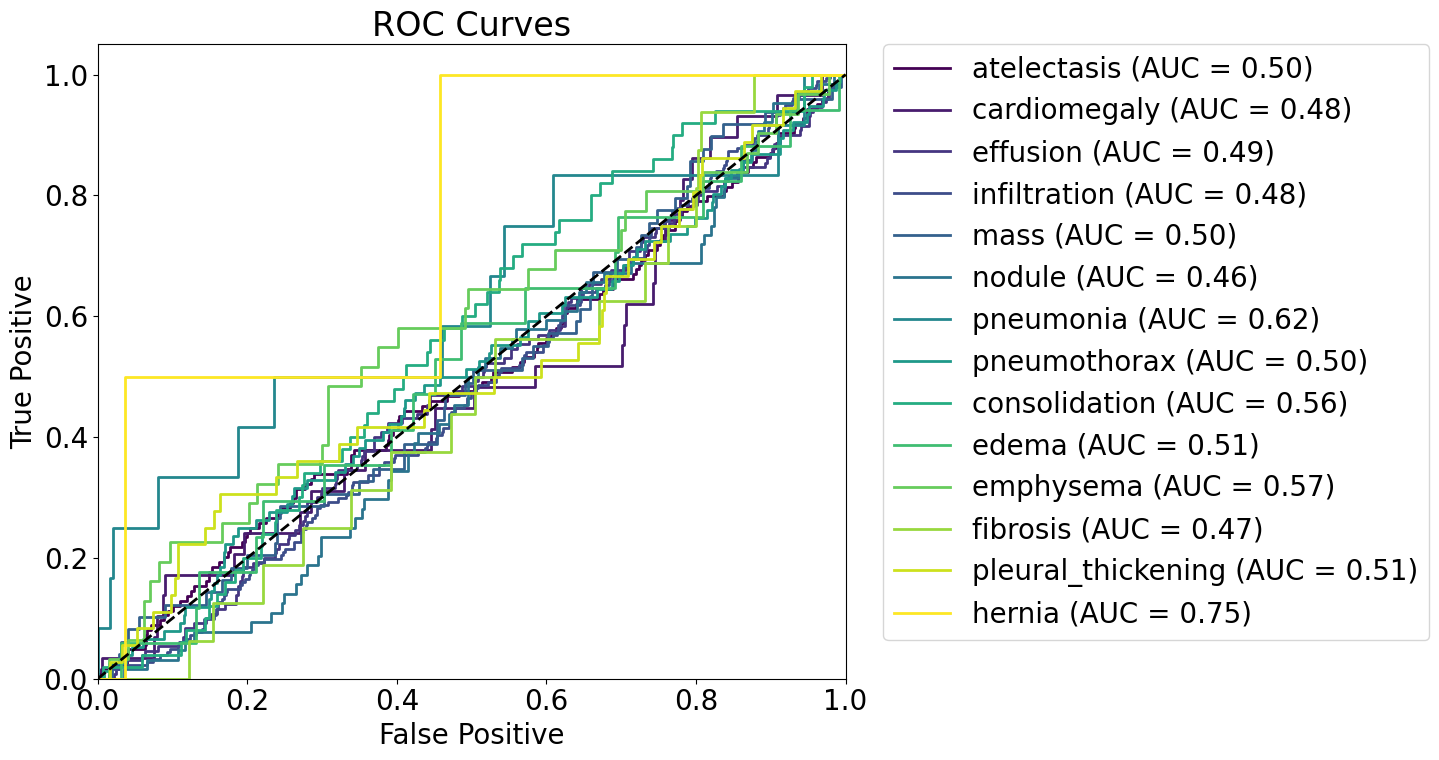

In [ ]:
plot_multilabel_roc(model=fusion_model, test_set = fusion_test_gen, batch_size=64, y_true=test_labels_64, class_labels = CLASS_LABELS)

###2) ResNet

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/resnet_global_64'

ResNet_global_64 , ResNet_global_64_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= ResNet(input_shape=(64,64,1), n_classes=14, variant="18"),
    train_generator=train_generator_64,
    val_generator=valid_generator_64,
    model_base=model_base
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 266ms/step - acc: 0.8999 - auc: 0.6353 - loss: 1.2538 - val_acc: 0.9508 - val_auc: 0.5000 - val_loss: 7689.3770 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9471 - auc: 0.7545 - loss: 0.9165 - val_acc: 0.9429 - val_auc: 0.6887 - val_loss: 0.6673 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.9474 - auc: 0.7436 - loss: 0.5191 - val_acc: 0.9318 - val_auc: 0.5691 - val_loss: 1.0107 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9474 - auc: 0.7505 - loss: 0.3531 - val_acc: 0.9522 - val_auc: 0.7431 - val_loss: 0.2988 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning ra

##### Evaluation

In [ ]:
plot_training_history(ResNet_global_64_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_64) / 64))

In [ ]:
evaluation = ResNet_global_64.evaluate(test_generator_64, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_R_G_64 = ResNet_global_64.predict(test_generator_64, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_64[:, i], y_prob_R_G_64[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_64,
    y_probs       = y_prob_R_G_64,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/resnet_global_64.keras"
history_path = '/content/drive/MyDrive/chestMNIST/resnet_global_64_history.pkl'

ResNet_global_64 = keras.models.load_model(model_path)
ResNet_global_64_history = pickle.load(open(history_path, 'rb'))

#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_64 = data_generator_2(train_images_64, train_labels_64, batch_size=1)
valid_generator2_64 = data_generator_2(val_images_64, val_labels_64, batch_size=1)
test_generator2_64 = data_generator_2(test_images_64, test_labels_64, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_resnet_64.npz")

num_samples = len(train_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, ResNet_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_resnet_64.npz")

num_samples = len(val_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, ResNet_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_resnet_64.npz")

num_samples = len(test_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, ResNet_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



##### Loading Bbox Images

In [ ]:
data_4 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_resnet_64.npz')
train_img_bbox_64_R = data_4['images']
train_img_bbox_64_R = np.squeeze(train_img_bbox_64_R)
train_lbl_bbox_64_R = data_4['labels']
train_lbl_bbox_64_R = np.squeeze(train_lbl_bbox_64_R)

In [ ]:
data_5 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_resnet_64.npz')
val_img_bbox_64_R = data_5['images']
val_img_bbox_64_R = np.squeeze(val_img_bbox_64_R)
val_lbl_bbox_64_R = data_5['labels']
val_lbl_bbox_64_R = np.squeeze(val_lbl_bbox_64_R)

In [ ]:
data_6 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_resnet_64.npz')
test_img_bbox_64_R = data_6['images']
test_img_bbox_64_R = np.squeeze(test_img_bbox_64_R)
test_lbl_bbox_64_R = data_6['labels']
test_lbl_bbox_64_R = np.squeeze(test_lbl_bbox_64_R)

##### Run the Model

In [ ]:
SEED = 42

In [ ]:
train_generator_64 = data_generator_1(train_img_bbox_64_R, train_lbl_bbox_64_R, batch_size=64, augmentation=True, seed=SEED)
valid_generator_64 = data_generator_1(val_img_bbox_64_R, val_lbl_bbox_64_R, batch_size=64, augmentation=False, seed=SEED)
test_generator_64 = data_generator_1(test_img_bbox_64_R, test_lbl_bbox_64_R,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/resnet_local_64'

ResNet_local_64 , ResNet_local_64_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= ResNet(input_shape=(64,64,1), n_classes=14, variant="18"),
    train_generator=train_generator_64,
    val_generator=valid_generator_64,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(ResNet_local_64_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_64) / 64))

In [ ]:
evaluation = ResNet_local_64.evaluate(test_generator_64, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_R_l_64 = ResNet_local_64.predict(test_generator_64, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_64[:, i], y_prob_R_l_64[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_64,
    y_probs       = y_prob_R_l_64,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/resnet_local_64.keras"
history_path = '/content/drive/MyDrive/chestMNIST/resnet_local_64_history.pkl'

CNN_local_64 = keras.models.load_model(model_path)
CNN_local_64_history = pickle.load(open(history_path, 'rb'))


#### 3- Fusion Branch

### 3) DenseNet_121

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/DenseNet_global_64'

DenseNet_global_64 , DenseNet_global_64_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= DenseNet121(input_shape=(64, 64, 1), num_classes= 14, growth_rate=16, reduction=0.5),
    train_generator=train_generator_64,
    val_generator=valid_generator_64,
    model_base=model_base
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - acc: 0.9142 - auc: 0.6755 - loss: 0.2647 - val_acc: 0.8232 - val_auc: 0.5066 - val_loss: 13695998.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - acc: 0.9476 - auc: 0.7581 - loss: 0.1919 - val_acc: 0.8860 - val_auc: 0.4990 - val_loss: 1655.3574 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - acc: 0.9477 - auc: 0.7567 - loss: 0.1898 - val_acc: 0.8813 - val_auc: 0.4796 - val_loss: 492.4074 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - acc: 0.9478 - auc: 0.7648 - loss: 0.1857 - val_acc: 0.9508 - val_auc: 0.5220 - val_loss: 14.6001 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting lea

##### Evaluation

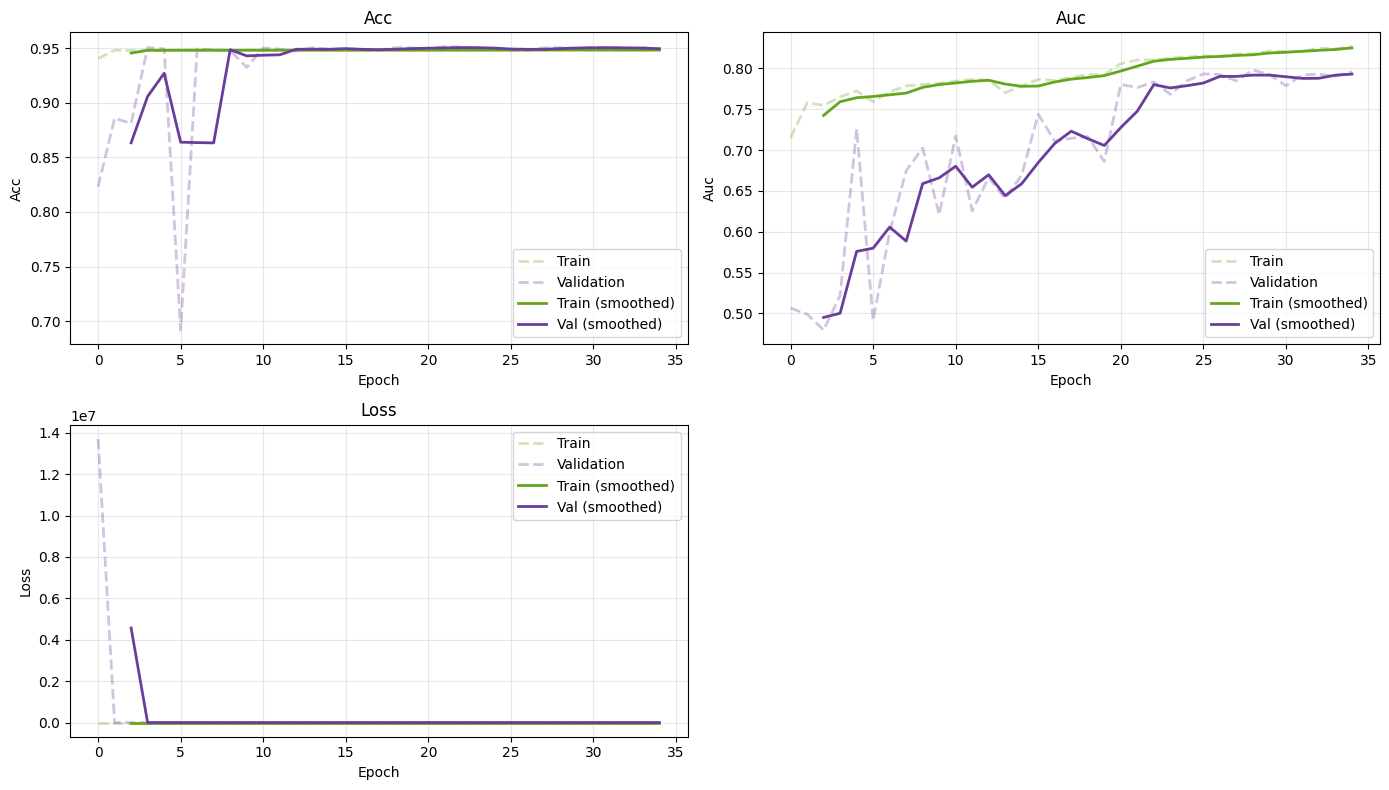

In [ ]:
plot_training_history(DenseNet_global_64_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_64) / 64))

In [ ]:
evaluation = DenseNet_global_64.evaluate(test_generator_64, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_D_G_64 = DenseNet_global_64.predict(test_generator_64, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_64[:, i], y_prob_D_G_64[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_64,
    y_probs       = y_prob_D_G_64,
    model_name    = "DenseNet_121")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/DenseNet_global_64.keras"
history_path = '/content/drive/MyDrive/chestMNIST/DenseNet_global_64_history.pkl'

DenseNet_global_64 = keras.models.load_model(model_path)
DenseNet_global_64_history = pickle.load(open(history_path, 'rb'))

-------------------------------------------------------

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<ipython-input-30-d7e10aa2e54f>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(model_names))


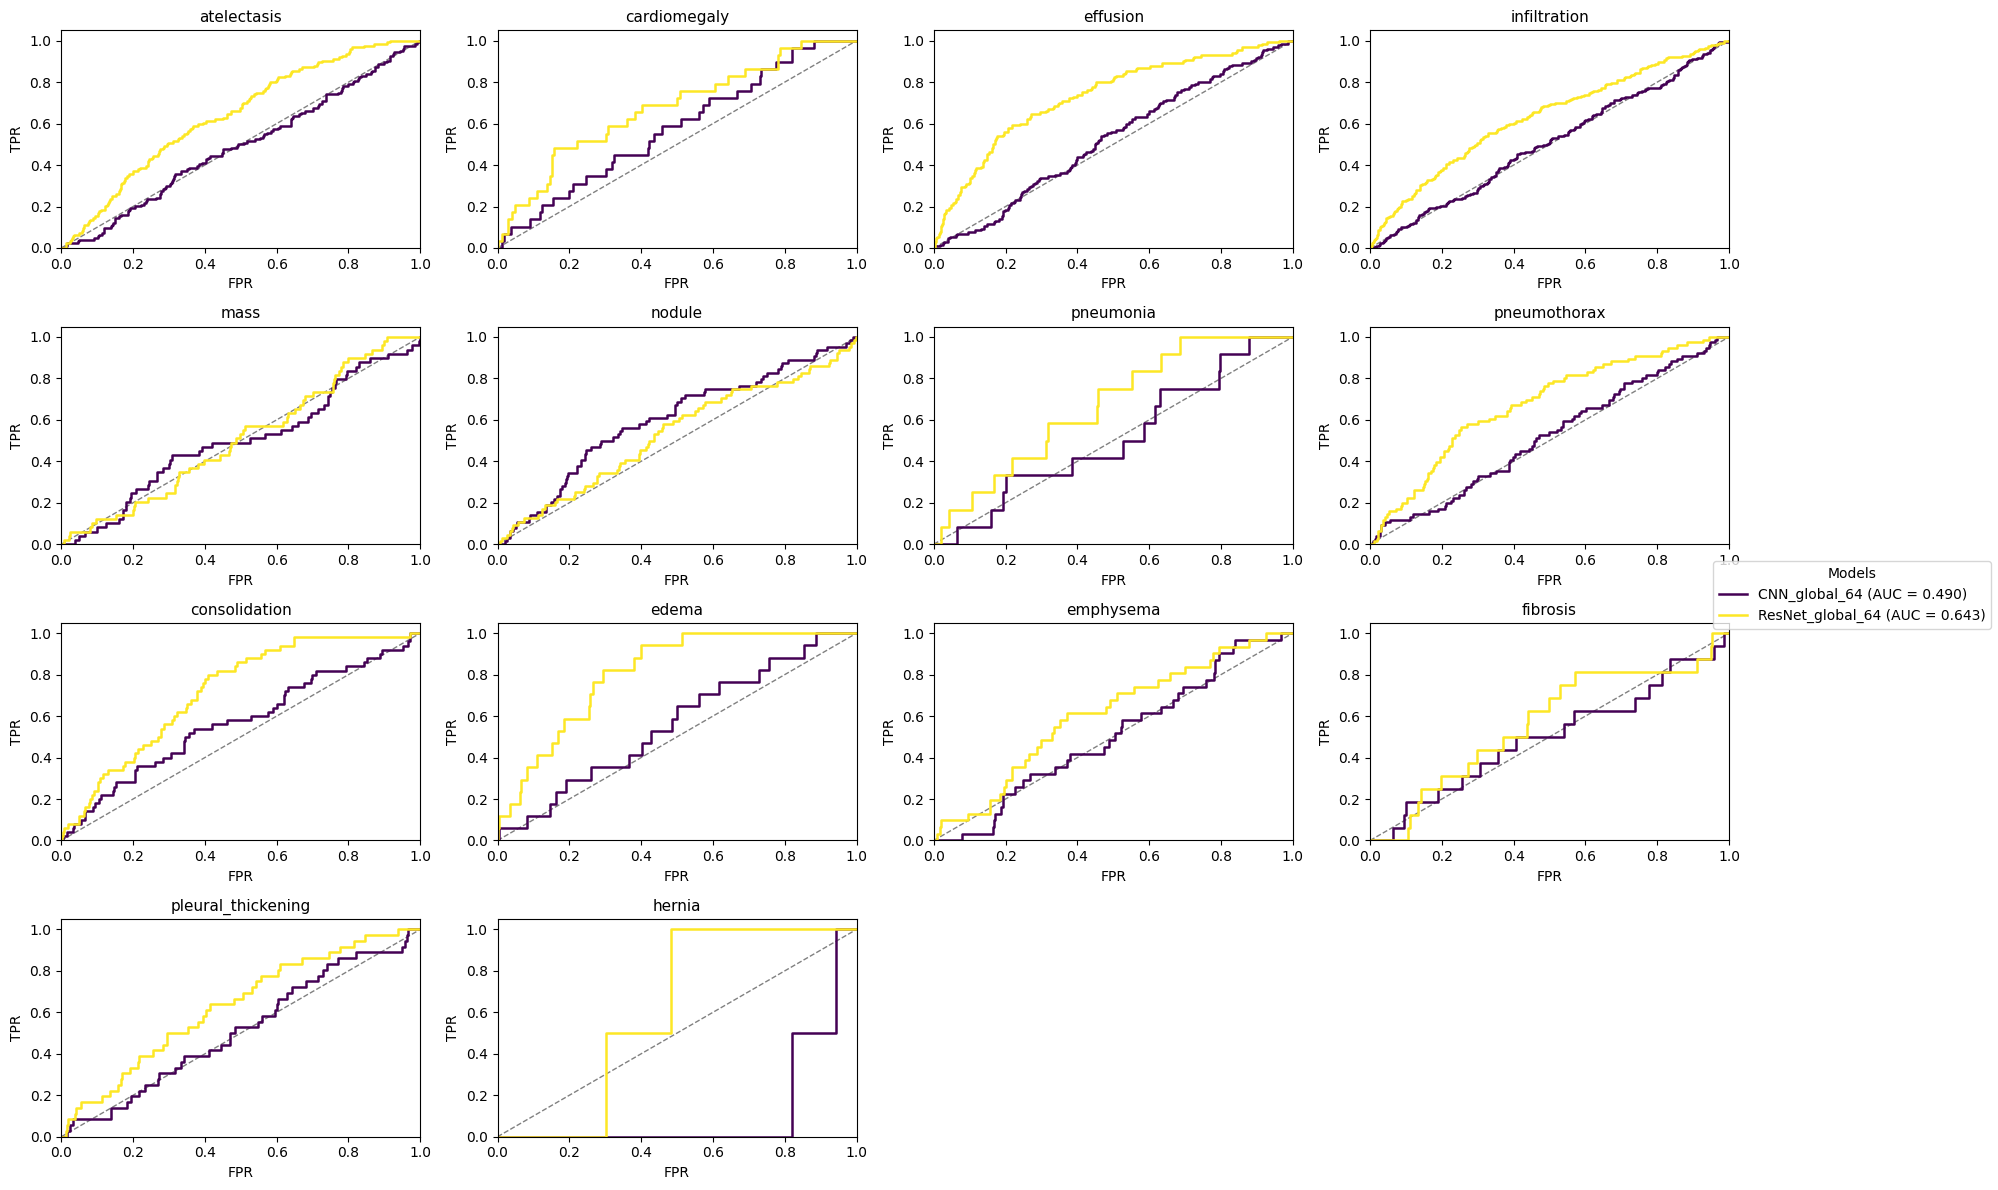

In [ ]:
steps = math.ceil(len(test_labels_64) / 64)
probs_CNN = CNN_global_64.predict(test_generator_64, steps=steps)
probs_Resnet  = ResNet_global_64.predict(test_generator_64, steps=steps)


plot_multimodel_roc(
    y_true           = test_labels_64,
    y_prob_list      = [probs_CNN, probs_Resnet],
    model_names      = ["CNN_global_64", "ResNet_global_64"],
    class_labels     = CLASS_LABELS,
    n_cols           = 4,           # 4 × 4 grid → 16 cells (14 used)
    figsize          = (20, 12),
    cmap_name      = "viridis"
)


_________________________________________________

#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_64 = data_generator_2(train_images_64, train_labels_64, batch_size=1)
valid_generator2_64 = data_generator_2(val_images_64, val_labels_64, batch_size=1)
test_generator2_64 = data_generator_2(test_images_64, test_labels_64, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_densenet_64.npz")

num_samples = len(train_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_densenet_64.npz")

num_samples = len(val_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_densenet_64.npz")

num_samples = len(test_images_64)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_64)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_64, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



##### Loading Bbox Images

In [ ]:
data_4 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_densenet_64.npz')
train_img_bbox_64_D = data_4['images']
train_img_bbox_64_D = np.squeeze(train_img_bbox_64_D)
train_lbl_bbox_64_D = data_4['labels']
train_lbl_bbox_64_D = np.squeeze(train_lbl_bbox_64_D)

In [ ]:
data_5 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_densenet_64.npz')
val_img_bbox_64_D = data_5['images']
val_img_bbox_64_D = np.squeeze(val_img_bbox_64_D)
val_lbl_bbox_64_D = data_5['labels']
val_lbl_bbox_64_D = np.squeeze(val_lbl_bbox_64_D)

In [ ]:
data_6 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_densenet_64.npz')
test_img_bbox_64_D = data_6['images']
test_img_bbox_64_D = np.squeeze(test_img_bbox_64_D)
test_lbl_bbox_64_D = data_6['labels']
test_lbl_bbox_64_D = np.squeeze(test_lbl_bbox_64_D)

##### Run the Model

In [ ]:
SEED = 42

In [ ]:
train_generator_64 = data_generator_1(train_img_bbox_64_D, train_lbl_bbox_64_D, batch_size=64, augmentation=True, seed=SEED)
valid_generator_64 = data_generator_1(val_img_bbox_64_D, val_lbl_bbox_64_D, batch_size=64, augmentation=False, seed=SEED)
test_generator_64 = data_generator_1(test_img_bbox_64_D, test_lbl_bbox_64_D,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/densenet_local_64'

DenseNet_local_64 , DenseNet_local_64_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= DenseNet121(input_shape=(64, 64, 1), num_classes= 14, growth_rate=16, reduction=0.5),
    train_generator=train_generator_64,
    val_generator=valid_generator_64,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(DenseNet_local_64_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_64) / 64))

In [ ]:
evaluation = ResNet_local_64.evaluate(test_generator_64, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_D_l_64 = DenseNet_local_64_history.predict(test_generator_64, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_64[:, i], y_prob_D_l_64[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_64,
    y_probs       = y_prob_D_l_64,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/densenet_local_64.keras"
history_path = '/content/drive/MyDrive/chestMNIST/densenet_local_64_history.pkl'

DenseNet_local_64 = keras.models.load_model(model_path)
DenseNet_local_64_history = pickle.load(open(history_path, 'rb'))

#### 3- Fusion Branch

##ChestMnist_128

In [ ]:
SEED = 42

In [ ]:
train_img_128, train_lbl_128, val_img_128, val_lbl_128, test_img_128, test_lbl_128 = load_dataset(128)

In [ ]:
train_images_128, train_labels_128 = subsample(train_img_128, train_lbl_128, seed=SEED)
val_images_128, val_labels_128   = subsample(val_img_128, val_lbl_128, seed=SEED)
test_images_128, test_labels_128  = subsample(test_img_128, test_lbl_128, seed=SEED)

In [ ]:
train_generator_128 = data_generator_1(train_images_128, train_labels_128, batch_size=64, augmentation=True, seed=SEED)
valid_generator_128 = data_generator_1(val_images_128, val_labels_128, batch_size=64, augmentation=False, seed=SEED)
test_generator_128 = data_generator_1(test_images_128, test_labels_128,batch_size=64, augmentation=False, seed=SEED)

### 1) 5layer_CNN

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/CNN_global_128'

CNN_global_128 , CNN_global_128_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model=CNN5layers((128, 128, 1), num_classes=14),
    train_generator=train_generator_128,
    val_generator=valid_generator_128,
    model_base=model_base
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - acc: 0.9100 - auc: 0.6556 - loss: 0.3661 - val_acc: 0.9508 - val_auc: 0.4999 - val_loss: 1.2202 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - acc: 0.9459 - auc: 0.7463 - loss: 0.2089 - val_acc: 0.9492 - val_auc: 0.7074 - val_loss: 0.2036 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - acc: 0.9460 - auc: 0.7472 - loss: 0.2040 - val_acc: 0.9497 - val_auc: 0.7151 - val_loss: 0.2029 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - acc: 0.9459 - auc: 0.7469 - loss: 0.2041 - val_acc: 0.9487 - val_auc: 0.7492 - val_loss: 0.1948 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - acc: 0.9460 

##### Evaluation

In [ ]:
plot_training_history(CNN_global_128_history, smoothing_window= 3, show_raw=True)

NameError: name 'CNN_global_128_history' is not defined

In [ ]:
steps = int(np.ceil(len(test_labels_128) / 64))

In [ ]:
evaluation = CNN_global_128.evaluate(test_generator_128, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_C_G_128 = CNN_global_128.predict(test_generator_128, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_128[:, i], y_prob_C_G_128[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_128,
    y_probs       = y_prob_C_G_128,
    model_name    = "5layer_CNN")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/CNN_global_128.keras"
history_path = '/content/drive/MyDrive/chestMNIST/CNN_global_128_history.pkl'

CNN_global_128 = keras.models.load_model(model_path)
CNN_global_128_history = pickle.load(open(history_path, 'rb'))


#### 2- Local Branch

##### Boundin Box

In [ ]:
batch_size = 1
train_generator2_128 = data_generator_2(train_images_128, train_labels_128, batch_size=1)
valid_generator2_128 = data_generator_2(val_images_128, val_labels_128, batch_size=1)
test_generator2_128 = data_generator_2(test_images_128, test_labels_128, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_CNN_128.npz")

num_samples = len(train_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_CNN_128.npz")

num_samples = len(val_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_CNN_128.npz")

num_samples = len(test_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



##### Loding BBOX Images

In [ ]:
data_4 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_CNN_128.npz')
train_img_bbox_128_cnn = data_4['images']
train_img_bbox_128_cnn = np.squeeze(train_img_bbox_128_cnn)
train_lbl_bbox_128_cnn = data_4['labels']
train_lbl_bbox_128_cnn = np.squeeze(train_lbl_bbox_128_cnn)

In [ ]:
data_5 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_CNN_128.npz')
val_img_bbox_128_cnn = data_5['images']
val_img_bbox_128_cnn = np.squeeze(val_img_bbox_128_cnn)
val_lbl_bbox_128_cnn = data_5['labels']
val_lbl_bbox_128_cnn = np.squeeze(val_lbl_bbox_128_cnn)

In [ ]:
data_6 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_CNN_128.npz')
test_img_bbox_128_cnn = data_6['images']
test_img_bbox_128_cnn = np.squeeze(val_img_bbox_128_cnn)
test_lbl_bbox_128_cnn = data_6['labels']
test_lbl_bbox_128_cnn = np.squeeze(val_lbl_bbox_128_cnn)

##### Run the Model

In [ ]:
SEED = 42

In [ ]:
train_generator_128 = data_generator_1(train_img_bbox_128_cnn, train_lbl_bbox_128_cnn, batch_size=64, augmentation=True, seed=SEED)
valid_generator_128 = data_generator_1(val_img_bbox_128_cnn, val_lbl_bbox_128_cnn, batch_size=64, augmentation=False, seed=SEED)
test_generator_128 = data_generator_1(test_img_bbox_128_cnn, test_lbl_bbox_128_cnn,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/CNN_local_128'

CNN_local_128 , CNN_local_128_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model=CNN5layers((64, 64, 1), num_classes=14),
    train_generator=train_generator_128,
    val_generator=valid_generator_128,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(CNN_local_128_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_128) / 64))

In [ ]:
evaluation = CNN_local_128.evaluate(test_generator_128, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_C_l_128 = CNN_local_128.predict(test_generator_128, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_128[:, i], y_prob_C_l_128[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_128,
    y_probs       = y_prob_C_l_128,
    model_name    = "5layer_CNN")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/CNN_local_128.keras"
history_path = '/content/drive/MyDrive/chestMNIST/CNN_local_128_history.pkl'

CNN_local_128 = keras.models.load_model(model_path)
CNN_local_128_history = pickle.load(open(history_path, 'rb'))

#### 3- Fiusion Branch

### 2) ResNet

#### 1- Global Model

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/ResNet_global_128'

ResNet_global_128 , ResNet_global_128_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= ResNet(input_shape=(128,128,1), n_classes=14, variant="18"),
    train_generator=train_generator_128,
    val_generator=valid_generator_128,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(ResNet_global_128_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_128) / 64))

In [ ]:
evaluation = ResNet_global_128.evaluate(test_generator_128, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_R_G_128 = ResNet_global_128.predict(test_generator_128, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_128[:, i], y_prob_R_G_128[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_128,
    y_probs       = y_prob_R_G_128,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/ResNet_global_128.keras"
history_path = '/content/drive/MyDrive/chestMNIST/ResNet_global_128_history.pkl'

ResNet_global_128 = keras.models.load_model(model_path)
ResNet_global_128_history = pickle.load(open(history_path, 'rb'))

#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_128 = data_generator_2(train_images_128, train_labels_128, batch_size=1)
valid_generator2_128 = data_generator_2(val_images_128, val_labels_128, batch_size=1)
test_generator2_128 = data_generator_2(test_images_128, test_labels_128, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_resnet_128.npz")

num_samples = len(train_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, ResNet_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_resnet_128.npz")

num_samples = len(val_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, ResNet_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_CNN_128.npz")

num_samples = len(test_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")

##### Loading Bbox Images

In [ ]:
data_4 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_resnet_128.npz')
train_img_bbox_128_R = data_4['images']
train_img_bbox_128_R = np.squeeze(train_img_bbox_128_R)
train_lbl_bbox_128_R = data_4['labels']
train_lbl_bbox_128_R = np.squeeze(train_lbl_bbox_128_R)

In [ ]:
data_5 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_resnet_128.npz')
val_img_bbox_128_R = data_5['images']
val_img_bbox_128_R = np.squeeze(val_img_bbox_128_R)
val_lbl_bbox_128_R = data_5['labels']
val_lbl_bbox_128_R = np.squeeze(val_lbl_bbox_128_R)

In [ ]:
data_6 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_resnet_128.npz')
test_img_bbox_128_R = data_6['images']
test_img_bbox_128_R = np.squeeze(test_img_bbox_128_R)
test_lbl_bbox_128_R = data_6['labels']
test_lbl_bbox_128_R = np.squeeze(test_lbl_bbox_128_R)

##### Run the Model

In [ ]:
SEED = 42

In [ ]:
train_generator_128 = data_generator_1(train_img_bbox_128_R, train_lbl_bbox_128_R, batch_size=64, augmentation=True, seed=SEED)
valid_generator_128 = data_generator_1(val_img_bbox_128_R, val_lbl_bbox_128_R, batch_size=64, augmentation=False, seed=SEED)
test_generator_128 = data_generator_1(test_img_bbox_128_R, test_lbl_bbox_128_R,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/resnet_local_128'

ResNet_local_128 , ResNet_local_128_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= ResNet(input_shape=(128,128,1), n_classes=14, variant="18"),
    train_generator=train_generator_128,
    val_generator=valid_generator_128,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(ResNet_local_128_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_128) / 64))

In [ ]:
evaluation = ResNet_local_128.evaluate(test_generator_128, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_R_l_128 = ResNet_local_128.predict(test_generator_128, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_128[:, i], y_prob_R_l_128[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_128,
    y_probs       = y_prob_R_l_128,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/resnet_local_128.keras"
history_path = '/content/drive/MyDrive/chestMNIST/resnet_local_128_history.pkl'

CNN_local_128 = keras.models.load_model(model_path)
CNN_local_128_history = pickle.load(open(history_path, 'rb'))


#### 3- Fusion Branch

### 3) DenseNet_121

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/DenseNet_global_128'

DenseNet_global_64 , DenseNet_global_64_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= DenseNet121(input_shape=(128, 128, 1), num_classes= 14, growth_rate=16, reduction=0.5),
    train_generator=train_generator_128,
    val_generator=valid_generator_128,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(DenseNet_global_128_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_128) / 64))

In [ ]:
evaluation = DenseNet_global_128.evaluate(test_generator_128, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_D_G_128 = DenseNet_global_128.predict(test_generator_128, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_128[:, i], y_prob_D_G_128[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_128,
    y_probs       = y_prob_D_G_128,
    model_name    = "DenseNet_121")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/DenseNet_global_128.keras"
history_path = '/content/drive/MyDrive/chestMNIST/DenseNet_global_128_history.pkl'

DenseNet_global_128 = keras.models.load_model(model_path)
DenseNet_global_128_history = pickle.load(open(history_path, 'rb'))

#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_128 = data_generator_2(train_images_128, train_labels_128, batch_size=1)
valid_generator2_128 = data_generator_2(val_images_128, val_labels_128, batch_size=1)
test_generator2_128 = data_generator_2(test_images_128, test_labels_128, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_densenet_128.npz")

num_samples = len(train_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_densenet_128.npz")

num_samples = len(val_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_densenet_128.npz")

num_samples = len(test_images_128)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_128)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_128, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



##### Loading Bbox Images

In [ ]:
data_4 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_densenet_128.npz')
train_img_bbox_128_D = data_4['images']
train_img_bbox_128_D = np.squeeze(train_img_bbox_128_D)
train_lbl_bbox_128_D = data_4['labels']
train_lbl_bbox_128_D = np.squeeze(train_lbl_bbox_128_D)

In [ ]:
data_5 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_densenet_128.npz')
val_img_bbox_128_D = data_5['images']
val_img_bbox_128_D = np.squeeze(val_img_bbox_128_D)
val_lbl_bbox_128_D = data_5['labels']
val_lbl_bbox_128_D = np.squeeze(val_lbl_bbox_128_D)

In [ ]:
data_6 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_densenet_128.npz')
test_img_bbox_128_D = data_6['images']
test_img_bbox_128_D = np.squeeze(test_img_bbox_128_D)
test_lbl_bbox_128_D = data_6['labels']
test_lbl_bbox_128_D = np.squeeze(test_lbl_bbox_128_D)

##### Run the Model

In [ ]:
SEED = 42

In [ ]:
train_generator_128 = data_generator_1(train_img_bbox_128_D, train_lbl_bbox_128_D, batch_size=64, augmentation=True, seed=SEED)
valid_generator_128 = data_generator_1(val_img_bbox_128_D, val_lbl_bbox_128_D, batch_size=64, augmentation=False, seed=SEED)
test_generator_128 = data_generator_1(test_img_bbox_128_D, test_lbl_bbox_128_D,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/densenet_local_128'

DenseNet_local_128 , DenseNet_local_128_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= DenseNet121(input_shape=(128, 128, 1), num_classes= 14, growth_rate=16, reduction=0.5),
    train_generator=train_generator_128,
    val_generator=valid_generator_128,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(DenseNet_local_128_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_128) / 64))

In [ ]:
evaluation = ResNet_local_128.evaluate(test_generator_128, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_D_l_128 = DenseNet_local_128_history.predict(test_generator_128, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_128[:, i], y_prob_D_l_128[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_128,
    y_probs       = y_prob_D_l_128,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/densenet_local_128.keras"
history_path = '/content/drive/MyDrive/chestMNIST/densenet_local_128_history.pkl'

DenseNet_local_128 = keras.models.load_model(model_path)
DenseNet_local_128_history = pickle.load(open(history_path, 'rb'))

#### 3- Fusion Branch

##ChestMnist_224

In [ ]:
SEED = 42

In [ ]:
train_img_224, train_lbl_224, val_img_224, val_lbl_224, test_img_224, test_lbl_224 = load_dataset(224)

In [ ]:
train_images_224, train_labels_224 = subsample(train_img_224, train_lbl_224, seed=SEED)
val_images_224, val_labels_224   = subsample(val_img_224, val_lbl_224, seed=SEED)
test_images_224, test_labels_224  = subsample(test_img_224, test_lbl_224, seed=SEED)

In [ ]:
train_generator_224 = data_generator_1(train_images_224, train_labels_224, batch_size=64, augmentation=True, seed=SEED)
valid_generator_224 = data_generator_1(val_images_224, val_labels_224, batch_size=64, augmentation=False, seed=SEED)
test_generator_224 = data_generator_1(test_images_224, test_labels_224,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
evaluation = ResNet_local_64.evaluate(test_generator_64, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

### 1) 5layer_CNN

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/CNN_global_224'

CNN_global_224 , CNN_global_224_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model=CNN5layers((224, 224, 1), num_classes=14),
    train_generator=train_generator_224,
    val_generator=valid_generator_224,
    model_base=model_base
)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1063: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(



Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - acc: 0.8937 - auc: 0.6557 - loss: 0.3408 - val_acc: 0.9508 - val_auc: 0.7369 - val_loss: 0.2231 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - acc: 0.9460 - auc: 0.7462 - loss: 0.1997 - val_acc: 0.9492 - val_auc: 0.7134 - val_loss: 0.2699 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - acc: 0.9459 - auc: 0.7452 - loss: 0.2000 - val_acc: 0.9497 - val_auc: 0.7321 - val_loss: 0.2346 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - acc: 0.9460 - auc: 0.7424 - loss: 0.2011 - val_acc: 0.9487 - val_auc: 0.7378 - val_loss: 0.2232 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning

##### Evaluation

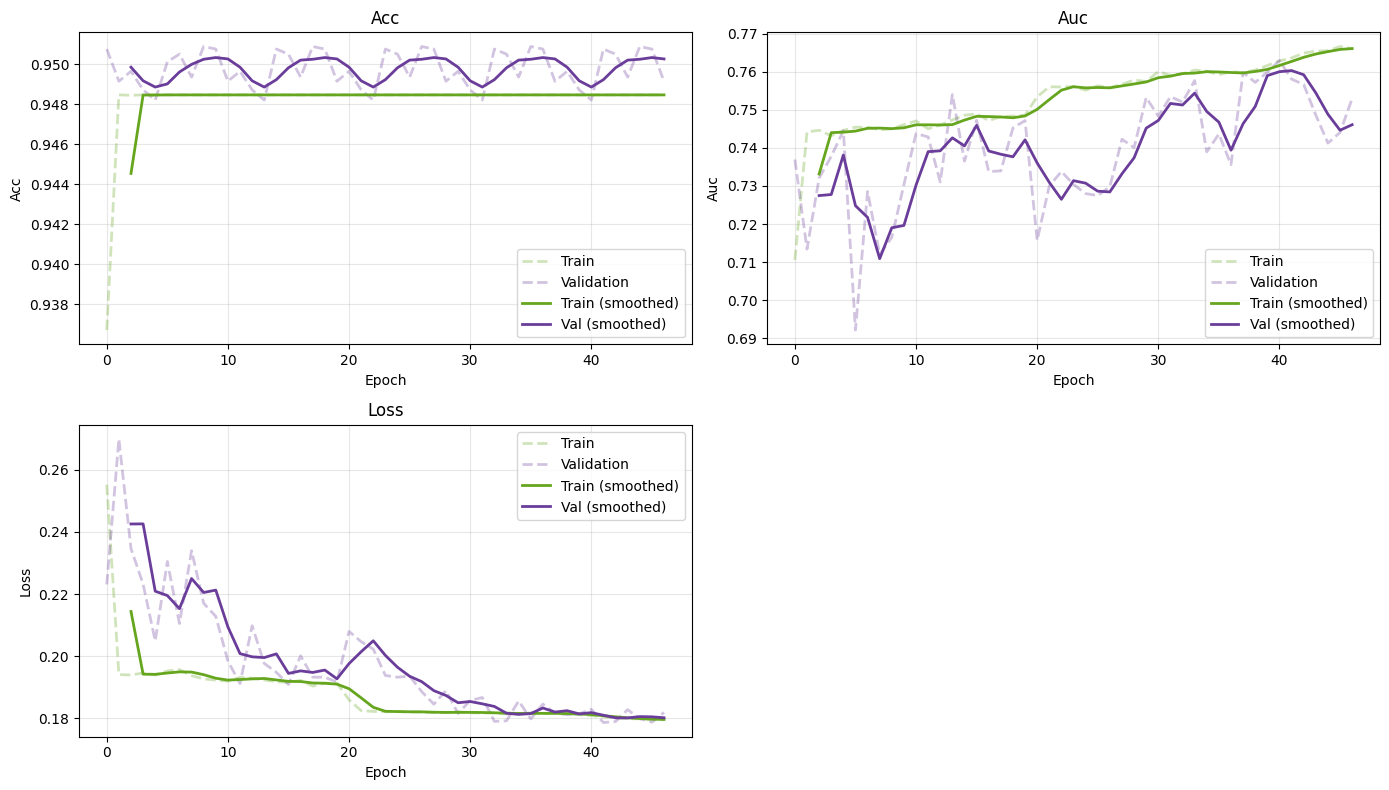

In [ ]:
plot_training_history(CNN_global_224_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_224) / 64))

In [ ]:
evaluation = CNN_global_224.evaluate(test_generator_224, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_C_G_224 = CNN_global_224.predict(test_generator_224, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_224[:, i], y_prob_C_G_224[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_224,
    y_probs       = y_prob_C_G_224,
    model_name    = "5layer_CNN")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/CNN_global_224.keras"
history_path = '/content/drive/MyDrive/chestMNIST/CNN_global_224_history.pkl'

CNN_global_224 = keras.models.load_model(model_path)
CNN_global_224_history = pickle.load(open(history_path, 'rb'))


#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_224 = data_generator_2(train_images_224, train_labels_224, batch_size=1)
valid_generator2_224 = data_generator_2(val_images_224, val_labels_224, batch_size=1)
test_generator2_224 = data_generator_2(test_images_224, test_labels_224, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_CNN_224.npz")

num_samples = len(train_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_CNN_224.npz")

num_samples = len(val_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_CNN_224.npz")

num_samples = len(test_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



##### Loding BBOX Images

In [ ]:
data_7 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_CNN_224.npz')
train_img_bbox_224_cnn = data_7['images']
train_img_bbox_224_cnn = np.squeeze(train_img_bbox_224_cnn)
train_lbl_bbox_224_cnn = data_7['labels']
train_lbl_bbox_224_cnn = np.squeeze(train_lbl_bbox_224_cnn)

In [ ]:
data_8 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_CNN_224.npz')
val_img_bbox_224_cnn = data_8['images']
val_img_bbox_224_cnn = np.squeeze(val_img_bbox_224_cnn)
val_lbl_bbox_224_cnn = data_8['labels']
val_lbl_bbox_224_cnn = np.squeeze(val_lbl_bbox_224_cnn)

In [ ]:
data_9 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_CNN_224.npz')
test_img_bbox_224_cnn = data_9['images']
test_img_bbox_224_cnn = np.squeeze(test_img_bbox_224_cnn)
test_lbl_bbox_224_cnn = data_9['labels']
test_lbl_bbox_224_cnn = np.squeeze(test_lbl_bbox_224_cnn)

##### Run the model

In [ ]:
SEED = 42

In [ ]:
train_generator_224 = data_generator_1(train_img_bbox_224_cnn, train_lbl_bbox_224_cnn, batch_size=64, augmentation=True, seed=SEED)
valid_generator_224 = data_generator_1(val_img_bbox_224_cnn, val_lbl_bbox_224_cnn, batch_size=64, augmentation=False, seed=SEED)
test_generator_224 = data_generator_1(test_img_bbox_224_cnn, test_lbl_bbox_224_cnn,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/CNN_local_224'

CNN_local_224 , CNN_local_224_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model=CNN5layers((64, 64, 1), num_classes=14),
    train_generator=train_generator_224,
    val_generator=valid_generator_224,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(CNN_local_224_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_224) / 64))

In [ ]:
evaluation = CNN_local_224.evaluate(test_generator_224, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_C_l_224 = CNN_local_224.predict(test_generator_224, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_224[:, i], y_prob_C_l_224[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_224,
    y_probs       = y_prob_C_l_224,
    model_name    = "5layer_CNN")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/CNN_local_224.keras"
history_path = '/content/drive/MyDrive/chestMNIST/CNN_local_224_history.pkl'

CNN_local_224 = keras.models.load_model(model_path)
CNN_local_224_history = pickle.load(open(history_path, 'rb'))

#### 3- Fiusion Branch

### 2) Resnet_50

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/ResNet_global_224'

ResNet_global_224 , ResNet_global_224_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= ResNet(input_shape=(224,224,1), n_classes=14, variant="18"),
    train_generator=train_generator_224,
    val_generator=valid_generator_224,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(ResNet_global_224_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_224) / 64))

In [ ]:
evaluation = ResNet_global_224.evaluate(test_generator_224, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_R_G_224 = ResNet_global_224.predict(test_generator_224, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_224[:, i], y_prob_R_G_224[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_224,
    y_probs       = y_prob_R_G_224,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/ResNet_global_224.keras"
history_path = '/content/drive/MyDrive/chestMNIST/ResNet_global_224_history.pkl'

ResNet_global_224 = keras.models.load_model(model_path)
ResNet_global_224_history = pickle.load(open(history_path, 'rb'))

#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_224 = data_generator_2(train_images_224, train_labels_224, batch_size=1)
valid_generator2_224 = data_generator_2(val_images_224, val_labels_224, batch_size=1)
test_generator2_224 = data_generator_2(test_images_224, test_labels_224, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_resnet_224.npz")

num_samples = len(train_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, ResNet_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_resnet_224.npz")

num_samples = len(val_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, ResNet_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_CNN_224.npz")

num_samples = len(test_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, CNN_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")

##### Loading Bbox Images

In [ ]:
data_4 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_resnet_224.npz')
train_img_bbox_224_R = data_4['images']
train_img_bbox_224_R = np.squeeze(train_img_bbox_224_R)
train_lbl_bbox_224_R = data_4['labels']
train_lbl_bbox_224_R = np.squeeze(train_lbl_bbox_224_R)

In [ ]:
data_5 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_resnet_224.npz')
val_img_bbox_224_R = data_5['images']
val_img_bbox_224_R = np.squeeze(val_img_bbox_224_R)
val_lbl_bbox_224_R = data_5['labels']
val_lbl_bbox_224_R = np.squeeze(val_lbl_bbox_224_R)

In [ ]:
data_6 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_resnet_224.npz')
test_img_bbox_224_R = data_6['images']
test_img_bbox_224_R = np.squeeze(test_img_bbox_224_R)
test_lbl_bbox_224_R = data_6['labels']
test_lbl_bbox_224_R = np.squeeze(test_lbl_bbox_224_R)

##### Run the Model

In [ ]:
SEED = 42

In [ ]:
train_generator_224 = data_generator_1(train_img_bbox_224_R, train_lbl_bbox_224_R, batch_size=64, augmentation=True, seed=SEED)
valid_generator_224 = data_generator_1(val_img_bbox_224_R, val_lbl_bbox_224_R, batch_size=64, augmentation=False, seed=SEED)
test_generator_224 = data_generator_1(test_img_bbox_224_R, test_lbl_bbox_224_R,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/resnet_local_224'

ResNet_local_224 , ResNet_local_224_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= ResNet(input_shape=(224,224,1), n_classes=14, variant="18"),
    train_generator=train_generator_224,
    val_generator=valid_generator_224,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(ResNet_local_224_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_224) / 64))

In [ ]:
evaluation = ResNet_local_224.evaluate(test_generator_224, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_R_l_224 = ResNet_local_224.predict(test_generator_224, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_224[:, i], y_prob_R_l_224[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_224,
    y_probs       = y_prob_R_l_224,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/resnet_local_224.keras"
history_path = '/content/drive/MyDrive/chestMNIST/resnet_local_224_history.pkl'

ResNet_local_224 = keras.models.load_model(model_path)
ResNet_local_224_history = pickle.load(open(history_path, 'rb'))


### 3) DenseNet_121

#### 1- Global Branch

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/DenseNet_global_224'

DenseNet_global_224 , DenseNet_global_224_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= DenseNet121(input_shape=(224, 224, 1),num_classes=14, growth_rate=16,reduction=0.5),
    train_generator=train_generator_224,
    val_generator=valid_generator_224,
    model_base=model_base
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - acc: 0.9138 - auc: 0.6627 - loss: 0.2550 - val_acc: 0.8809 - val_auc: 0.4706 - val_loss: 28399086.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - acc: 0.9499 - auc: 0.7491 - loss: 0.1841 - val_acc: 0.6513 - val_auc: 0.5428 - val_loss: 1886.5605 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - acc: 0.9499 - auc: 0.7599 - loss: 0.1794 - val_acc: 0.5830 - val_auc: 0.5709 - val_loss: 33.9777 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - acc: 0.9500 - auc: 0.7637 - loss: 0.1767 - val_acc: 0.9487 - val_auc: 0.7076 - val_loss: 0.2181 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting

##### Evaluation

In [ ]:
plot_training_history(DenseNet_global_224_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_224) / 64))

In [ ]:
evaluation = DenseNet_global_224.evaluate(test_generator_224, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_D_G_224 = DenseNet_global_224.predict(test_generator_224, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_224[:, i], y_prob_D_G_224[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_224,
    y_probs       = y_prob_D_G_224,
    model_name    = "DenseNet_121")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/DenseNet_global_224.keras"
history_path = '/content/drive/MyDrive/chestMNIST/DenseNet_global_224_history.pkl'

DenseNet_global_224 = keras.models.load_model(model_path)
DenseNet_global_224_history = pickle.load(open(history_path, 'rb'))

#### 2- Local Branch

##### Bounding Box

In [ ]:
batch_size = 1
train_generator2_224 = data_generator_2(train_images_224, train_labels_224, batch_size=1)
valid_generator2_224 = data_generator_2(val_images_224, val_labels_224, batch_size=1)
test_generator2_224 = data_generator_2(test_images_224, test_labels_224, batch_size=1)

In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_bbox_densenet_224.npz")

num_samples = len(train_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(train_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "val_bbox_densenet_224.npz")

num_samples = len(val_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,      # hide the bar once it finishes
            ncols=80,         # fixed width instead of “exploding” in Colab
            mininterval=0.2)  # don’t redraw more often than every 0.2 s


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(valid_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



In [ ]:
# ── 0.  House‑keeping ─────────────────────────────────────────────────────────
out_dir  = "/content/drive/MyDrive/chestMNIST/BBox"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "test_bbox_densenet_224.npz")

num_samples = len(test_images_224)                     # total images we expect
cropped_images_list, labels_list, bboxes_list = [], [], []

processed = 0                                          # how many images done

pbar = tqdm(total=num_samples,
            desc='Processing images',
            unit='img',
            leave=False,
            ncols=80,
            mininterval=0.2)


# ── 1.  Loop until we have seen every image exactly once ──────────────────────
while processed < num_samples:
    img, lbl = next(test_generator2_224)              # a *batch*
    B = img.shape[0]                                   # batch size

    heatmaps = generate_heatmaps_batch(img, DenseNet_global_224, "conv2d_4", "dense")

    avg_heatmaps  = heatmaps.mean(axis=-1)                        # (B, h, w)
    avg_heatmaps /= avg_heatmaps.max(axis=(1,2), keepdims=True)   # → [0,1]

    bboxes_batch  = []
    cropped_batch = []
    for hm, im in zip(avg_heatmaps, img):
      mask  = heatmap_to_mask(hm, thresh=0.5)                   # tweak ≥ 0.5
      bbox  = mask_to_bbox(mask)

      # fall-back: if mask empty, use a centred square
      if bbox is None:
        H, W = im.shape[:2]
        side = min(H, W)
        y0   = (H - side)//2
        x0   = (W - side)//2
        bbox = (x0, y0, x0+side-1, y0+side-1)

    bboxes_batch.append(bbox)
    cropped = crop_and_resize(im.squeeze(), bbox)[..., None]  # back to (H,W,1)
    cropped_batch.append(cropped.astype(float))

    cropped_batch = np.array(cropped_batch)

    cropped_images_list.append(cropped_batch)
    labels_list.append(lbl)
    bboxes_list.append(np.array(bboxes_batch))


    processed += B
    pbar.update(B)

pbar.close()

# ── 2.  Save everything ───────────────────────────────────────────────────────
np.savez_compressed(
    out_path,
    images = np.concatenate(cropped_images_list, axis=0)[:num_samples],
    labels = np.concatenate(labels_list,        axis=0)[:num_samples],
    bboxes = np.concatenate(bboxes_list,        axis=0)[:num_samples]
)


print(f"\nDone!  Saved one epoch of masked data to:\n{out_path}")



##### Loading Bbox Images

In [ ]:
data_4 = np.load('/content/drive/MyDrive/chestMNIST/BBox/train_bbox_densenet_224.npz')
train_img_bbox_224_D = data_4['images']
train_img_bbox_224_D = np.squeeze(train_img_bbox_224_D)
train_lbl_bbox_224_D = data_4['labels']
train_lbl_bbox_224_D = np.squeeze(train_lbl_bbox_224_D)

In [ ]:
data_5 = np.load('/content/drive/MyDrive/chestMNIST/BBox/val_bbox_densenet_224.npz')
val_img_bbox_224_D = data_5['images']
val_img_bbox_224_D = np.squeeze(val_img_bbox_224_D)
val_lbl_bbox_224_D = data_5['labels']
val_lbl_bbox_224_D = np.squeeze(val_lbl_bbox_224_D)

In [ ]:
data_6 = np.load('/content/drive/MyDrive/chestMNIST/BBox/test_bbox_densenet_224.npz')
test_img_bbox_224_D = data_6['images']
test_img_bbox_224_D = np.squeeze(test_img_bbox_224_D)
test_lbl_bbox_224_D = data_6['labels']
test_lbl_bbox_224_D = np.squeeze(test_lbl_bbox_224_D)

##### Run the Model

In [ ]:
SEED = 42

In [ ]:
train_generator_128 = data_generator_1(train_img_bbox_224_D, train_lbl_bbox_224_D, batch_size=64, augmentation=True, seed=SEED)
valid_generator_224 = data_generator_1(val_img_bbox_224_D, val_lbl_bbox_224_D, batch_size=64, augmentation=False, seed=SEED)
test_generator_224 = data_generator_1(test_img_bbox_224_D, test_lbl_bbox_224_D,batch_size=64, augmentation=False, seed=SEED)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/densenet_local_224'

DenseNet_local_224 , DenseNet_local_224_history = run_experiment(
    loss='binary_crossentropy',
    batch_size=64,
    num_epochs=50,
    model= DenseNet121(input_shape=(224, 224, 1), num_classes= 14, growth_rate=16, reduction=0.5),
    train_generator=train_generator_224,
    val_generator=valid_generator_224,
    model_base=model_base
)

##### Evaluation

In [ ]:
plot_training_history(DenseNet_local_224_history, smoothing_window= 3, show_raw=True)

In [ ]:
steps = int(np.ceil(len(test_labels_224) / 64))

In [ ]:
evaluation = ResNet_local_224.evaluate(test_generator_224, steps=steps, verbose=0)
print(f"Test loss     : {evaluation[0]:.4f}")
print(f"Test accuracy : {evaluation[1]:.4f}")
print(f"Test AUC      : {evaluation[2]:.4f}")

In [ ]:
y_prob_D_l_224 = DenseNet_local_224_history.predict(test_generator_224, steps=steps, verbose=0)

In [ ]:
per_class_auc = {}
for i, label in enumerate(CLASS_LABELS):
    try:
        per_class_auc[label] = roc_auc_score(test_labels_224[:, i], y_prob_D_l_224[:, i])
    except ValueError:
        per_class_auc[label] = np.nan

print("\nPer-class AUROC")
print("-" * 80)
for k, v in per_class_auc.items():
    print(f"{k:20s}: {v if not np.isnan(v) else 'undef'}")
results = {"metrics": metrics,
           "per_class_auc": per_class_auc}

In [ ]:
plot_multiclass_roc (
    y_true        = test_labels_224,
    y_probs       = y_prob_D_l_224,
    model_name    = "ResNet_18")

In [ ]:
model_path   = "/content/drive/MyDrive/chestMNIST/densenet_local_224.keras"
history_path = '/content/drive/MyDrive/chestMNIST/densenet_local_224_history.pkl'

DenseNet_local_224 = keras.models.load_model(model_path)
DenseNet_local_224_history = pickle.load(open(history_path, 'rb'))

#### 3- Fusion Branch

# Gosheie baraye save mohtavaye ghadim

In [ ]:
import os, time, math, pickle, psutil, tensorflow as tf

def run_experiment(loss, batch_size, num_epochs, model,
                   train_generator, val_generator,
                   model_base, initial_lr = 0.01):                 # pass *base* path, no ext
    # ---------- compile ----------
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
                 tf.keras.metrics.AUC(name="auc")]
    )

    steps_per_epoch  = math.ceil(len(train_images_64) / batch_size)
    validation_steps = math.ceil(len(val_images_64)   / batch_size)

    # ---------- callbacks ----------
    callbacks = [
        # 1) stop training if val-AUC hasn’t improved for 6 epochs
        tf.keras.callbacks.EarlyStopping(
            monitor='val_acc', mode='max',
            patience=6, restore_best_weights=True, verbose=1),

        # 2) keep a copy of the best model weights *while* training
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{model_base}_best.keras',
            monitor='val_auc', mode='max',
            save_best_only=True, verbose=1),


        # 4) one-line CSV of the metrics after every epoch
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch, lr: initial_lr * 0.1 ** (epoch // 20),  # ↓10× every 20 epochs
            verbose=1)
    ]

    # ---------- train ----------
    t0 = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,                 # ← new line
        verbose=1
    )
    print(f"Training took {time.time() - t0:.1f}s")

    # ---------- save final model & history ----------
    model_file   = f'{model_base}.keras'
    history_file = f'{model_base}_history.pkl'
    os.makedirs(os.path.dirname(model_file), exist_ok=True)

    model.save(model_file)
    pickle.dump(history.history, open(history_file, 'wb'))

    # ---------- memory usage ----------
    mem_mb = psutil.Process().memory_info().rss / 1_048_576
    print(f"Current memory usage: {mem_mb:.2f} MB")

    print("saved:", model_file)
    print("saved:", history_file)
    return model, history


in hamoon noskhe data_generator hast ke khodet gozashte budi avval. bad chon random mishod male chat ro gozashti

In [ ]:
def data_generator(images, labels, batch_size, augmentation=True):
    generator = get_datagen(augmentation)
    while True:
        idxs = np.arange(len(images))

        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_idx = idxs[start:end]
            batch_imgs = images[batch_idx]
            batch_lbls = labels[batch_idx]

            # Ensure images have shape (batch, h, w, 1)
            if batch_imgs.ndim == 3:
                batch_imgs = np.expand_dims(batch_imgs, -1)

            augmented = np.stack([generator.random_transform(img) for img in batch_imgs])
            yield augmented, batch_lbls


### eee

In [ ]:
def dual_data_generator(global_images, local_images, labels, batch_size, datagen=None):
    while True:
        indices = np.arange(len(labels))
        # np.random.shuffle(indices)

        for start in range(0, len(labels), batch_size):
            end = min(start + batch_size, len(labels))
            batch_indices = indices[start:end]

            batch_global_images = global_images[batch_indices]
            batch_local_images = local_images[batch_indices]
            batch_labels = labels[batch_indices]

            # Add channel dimension for grayscale images
            batch_global_images = np.expand_dims(batch_global_images, axis=-1)
            batch_local_images = np.expand_dims(batch_local_images, axis=-1)

            # Apply augmentation if provided
            if datagen:
                batch_global_images = np.array([datagen.random_transform(img) for img in batch_global_images])
                batch_local_images = np.array([datagen.random_transform(img) for img in batch_local_images])

            yield (batch_global_images, batch_local_images), batch_labels


In [ ]:
# Function to rename the layers of a model
def rename_model_layers(model, prefix):
    config = model.get_config()
    for layer in config['layers']:
        layer['config']['name'] = prefix + layer['config']['name']
    new_model = Model.from_config(config)
    new_model.set_weights(model.get_weights())
    return new_model

In [ ]:
# Create the fusion model
def create_fusion_model(global_model, local_model):

    K.clear_session()

    for layer in global_branch.layers:
      layer.trainable = False

    for layer in local_branch.layers:
      layer.trainable = False

    # Take the outputs of the last pooling layers
    global_output = global_model.get_layer('global_global_average_pooling2d').output
    global_output = layers.Dense(14, activation='sigmoid')(global_output)
    local_output = local_model.get_layer('local_global_average_pooling2d_1').output
    local_output = layers.Dense(14, activation='sigmoid')(local_output)
    # Concatenate the outputs of the global and local branches
    combined_input = layers.concatenate([global_output, local_output])

    x = layers.Dense(14, activation='sigmoid')(combined_input)

    model = models.Model(inputs=[global_model.input, local_model.input], outputs=x)
    return model

In [ ]:
batch_size = 32
train_generator = dual_data_generator(train_images_64, train_img_bbox_64_cnn, train_labels_64, batch_size)
val_generator = dual_data_generator(val_images_64, val_img_bbox_64_cnn, val_labels_64, batch_size)
test_generator = dual_data_generator(test_images_64, test_img_bbox_64_cnn, test_labels_64, batch_size)

In [ ]:
# Load the pre-trained global and local models
global_branch = load_model('/content/drive/MyDrive/chestMNIST/CNN_global_64.keras')
local_branch = load_model('/content/drive/MyDrive/chestMNIST/CNN_local_64.keras')

In [ ]:
# Rename the layers of the global and local models
global_branch = rename_model_layers(global_branch, 'global_')
local_branch = rename_model_layers(local_branch, 'local_')

In [ ]:
global_branch.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_input_layer (InputLayer) │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_conv2d (Conv2D)          │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_batch_normalization      │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_re_lu (ReLU)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_dropout (Dropout)        │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_conv2d_1 (Conv2D)        │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_batch_normalization_1    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_re_lu_1 (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_dropout_1 (Dropout)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_conv2d_2 (Conv2D)        │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_batch_normalization_2    │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_re_lu_2 (ReLU)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 8, 8, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_dropout_2 (Dropout)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_conv2d_3 (Conv2D)        │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_batch_normalization_3    │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_re_lu_3 (ReLU)           │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 4, 4, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_dropout_3 (Dropout)      │ (None, 4, 4, 256)      │             

 Total params: 984,462 (3.76 MB)

 Trainable params: 982,990 (3.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
local_branch.summary()

Model: "functional_5605"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ local_input_layer_1             │ (None, 64, 64, 1)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_conv2d_5 (Conv2D)         │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_batch_normalization_5     │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_re_lu_5 (ReLU)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_max_pooling2d_4           │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_dropout_4 (Dropout)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_batch_normalization_6     │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_re_lu_6 (ReLU)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_max_pooling2d_5           │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_dropout_5 (Dropout)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_batch_normalization_7     │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_re_lu_7 (ReLU)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_max_pooling2d_6           │ (None, 8, 8, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_dropout_6 (Dropout)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_conv2d_8 (Conv2D)         │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_batch_normalization_8     │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_re_lu_8 (ReLU)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ local_max_pooling2d_7           │ (None, 4, 4, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 984,462 (3.76 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 984,462 (3.76 MB)

In [ ]:
model_base = '/content/drive/MyDrive/chestMNIST/CNN_fiusion_64'
simple_model_BCE_fusion, simple_model_BCE_fusion_history = run_experiment(
    loss = 'binary_crossentropy',
    batch_size = 32,
    num_epochs = 50,
    model = create_fusion_model(global_branch, local_branch),
    train_generator = train_generator,
    val_generator = val_generator,
    model_base = model_base
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - acc: 0.8956 - auc: 0.6255 - loss: 0.2859 - val_acc: 0.9508 - val_auc: 0.7442 - val_loss: 0.1776 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9458 - auc: 0.7503 - loss: 0.1884 - val_acc: 0.9520 - val_auc: 0.7474 - val_loss: 0.1740 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9458 - auc: 0.7582 - loss: 0.1865 - val_acc: 0.9504 - val_auc: 0.7512 - val_loss: 0.1780 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9458 - auc: 0.7632 - loss: 0.1855 - val_acc: 0.9504 - val_auc: 0.7508 - val_loss: 0.1781 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning r

Test loss     : 0.1906
Test accuracy : 0.9448
Test AUC      : 0.7590

Classification report
--------------------------------------------------------------------------------
                    precision    recall  f1-score   support

       atelectasis       0.13      0.82      0.22        66
      cardiomegaly       0.00      0.00      0.00        15
          effusion       0.12      0.99      0.22        67
      infiltration       0.17      0.99      0.29        95
              mass       0.05      0.85      0.10        26
            nodule       0.07      0.97      0.12        36
         pneumonia       0.02      0.75      0.04         8
      pneumothorax       0.09      0.10      0.09        31
     consolidation       0.20      0.04      0.06        26
             edema       0.03      0.36      0.05        11
         emphysema       0.03      0.94      0.06        18
          fibrosis       0.01      0.17      0.02         6
pleural_thickening       0.04      0.85      0

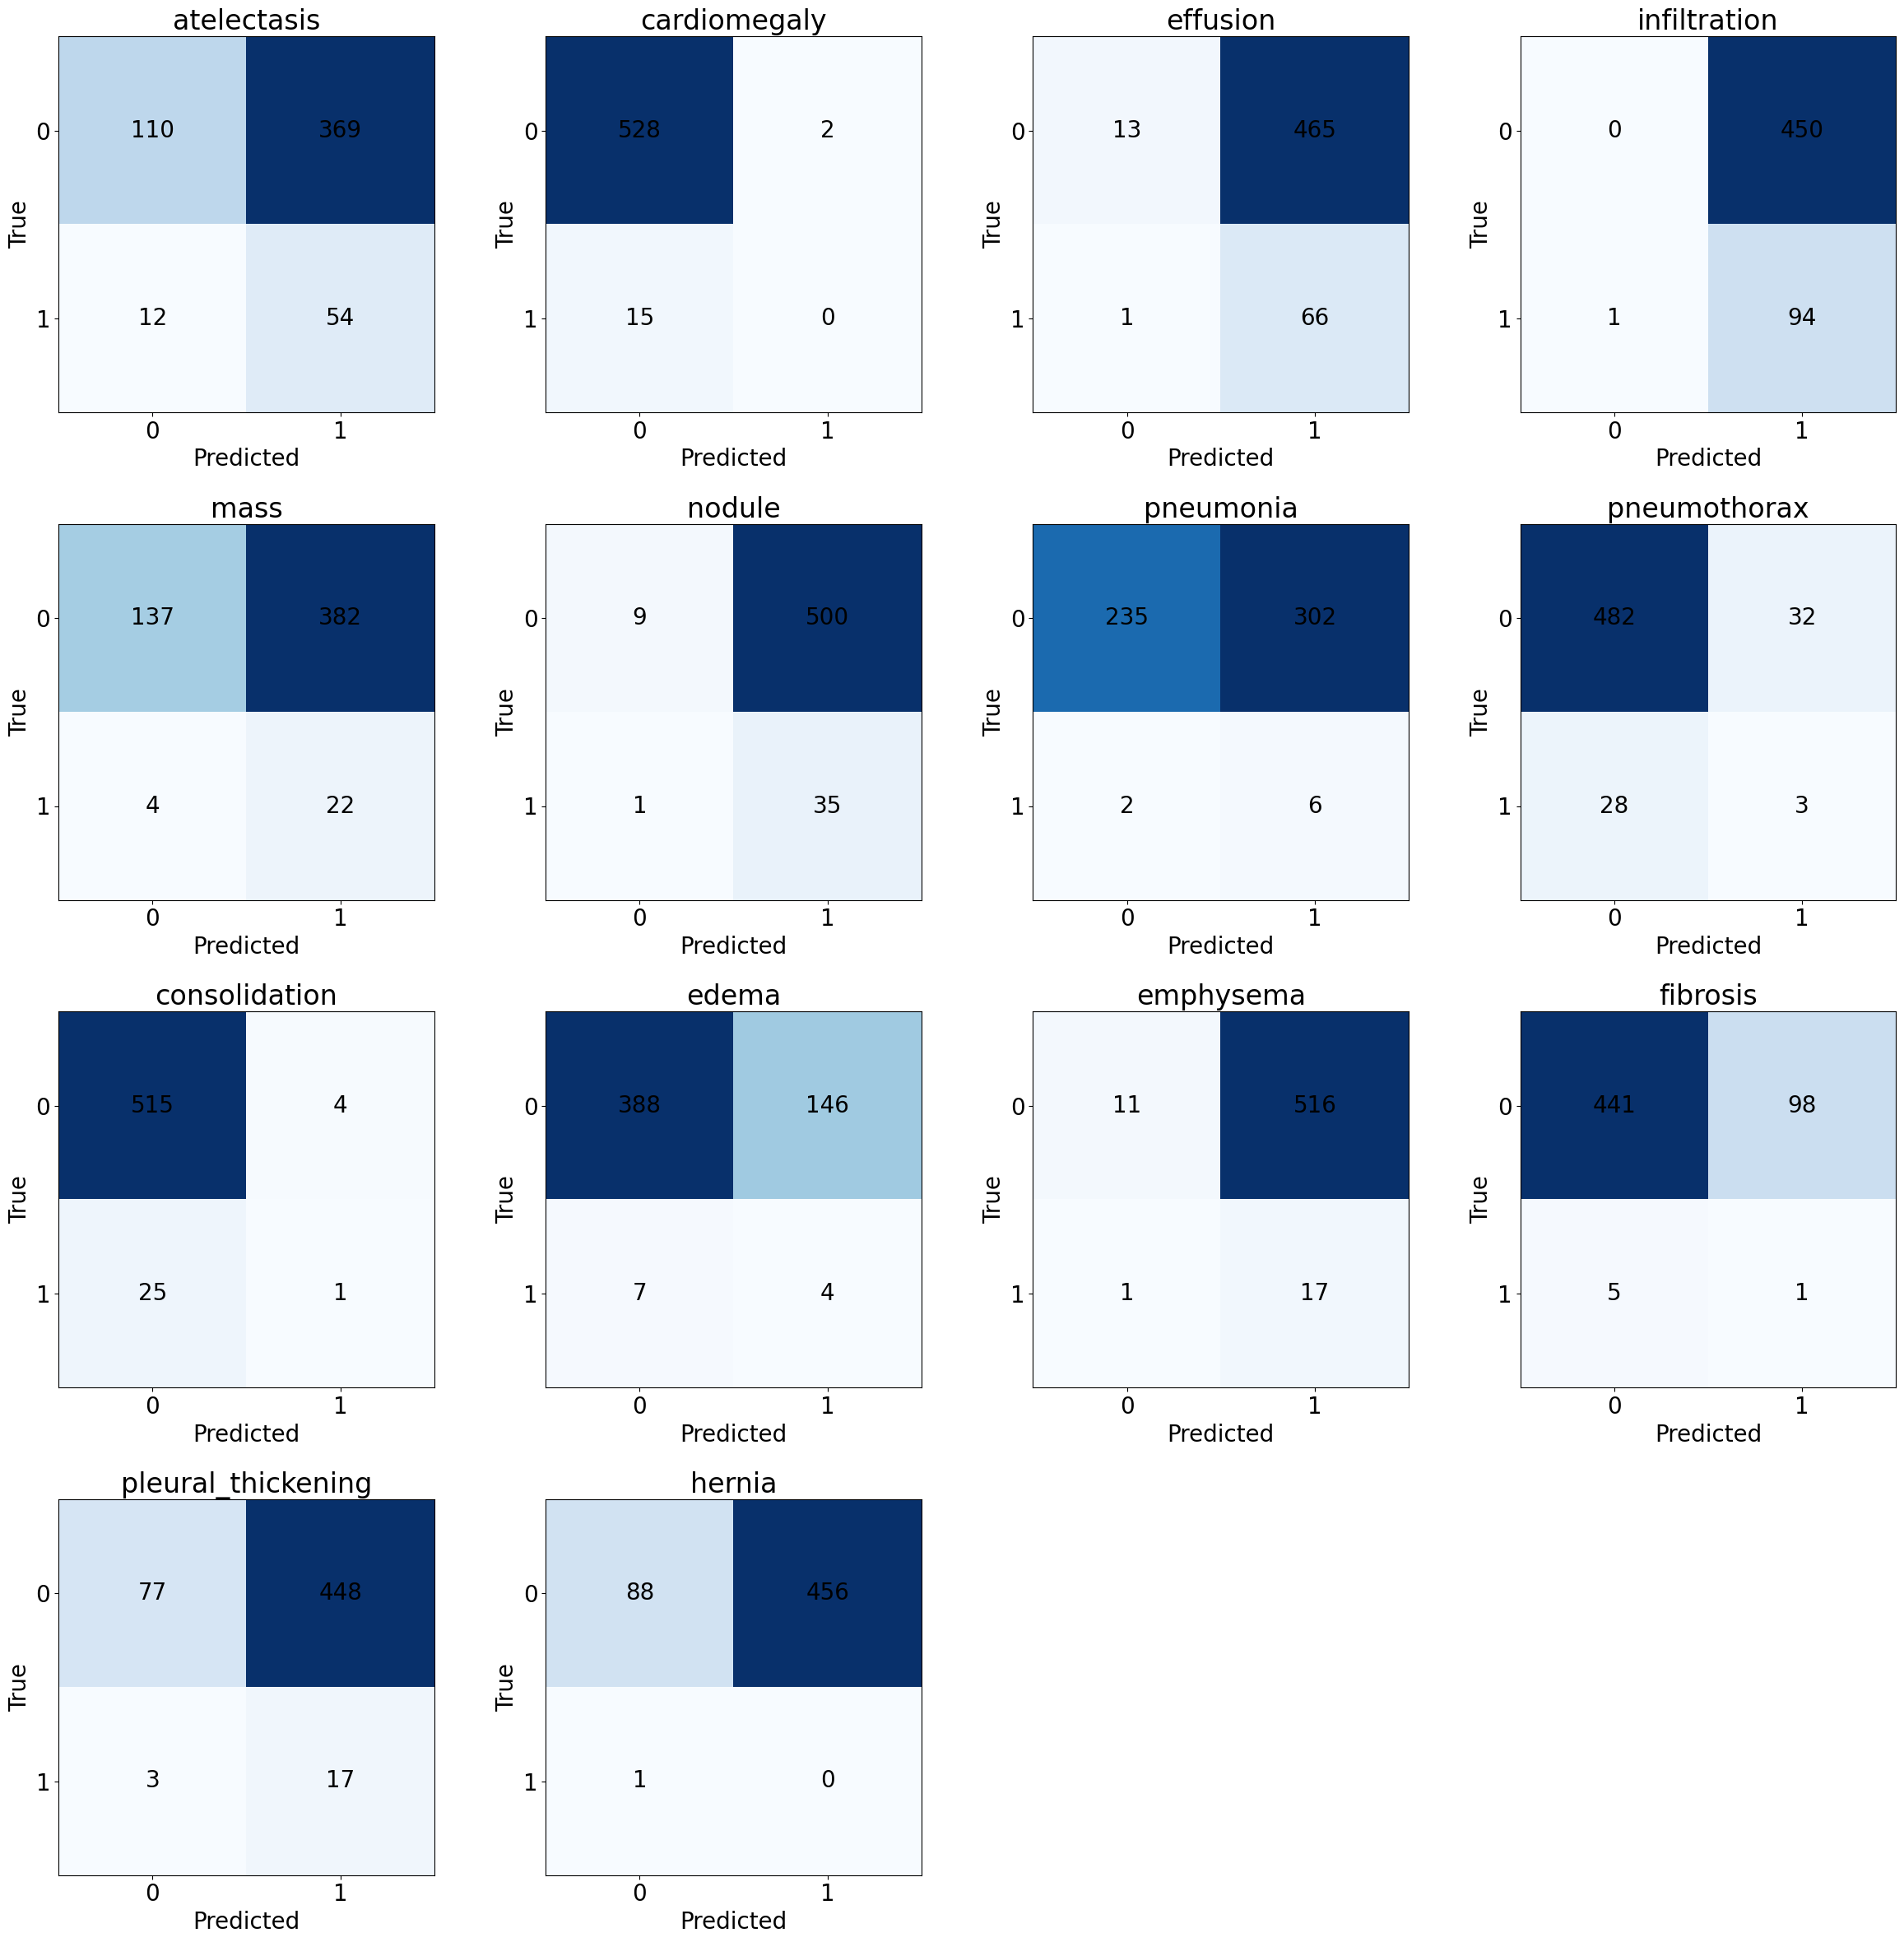

In [ ]:
results = evaluate_multilabel_model(simple_model_BCE_fusion,
                          test_generator,
                          test_labels_64,
                          CLASS_LABELS,
                          batch_size=64,
                          threshold_strategy="f1")

In [ ]:
plot_multilabel_roc(model= simple_model_BCE_fusion, test_set = test_generator, batch_size=64, y_true=test_labels_64, class_labels = CLASS_LABELS)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'get_cmap'

<Figure size 1500x800 with 0 Axes>

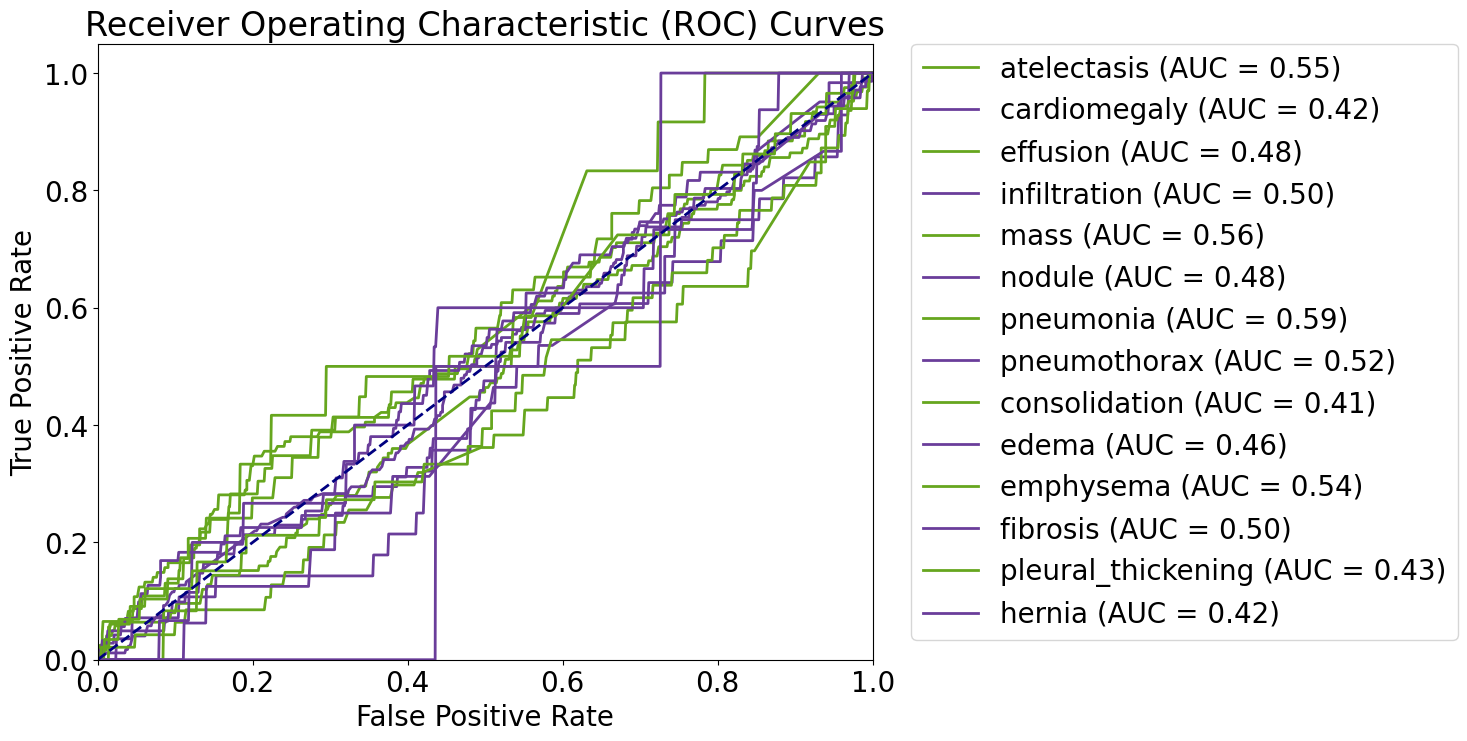

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:corrected_len, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.9527 - auc: 0.7023 - loss: 0.1966
Test Loss: 0.19821015000343323
Test AUC: 0.7159045934677124
Test Binary Accuracy: 0.9506900310516357
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
                     precision    recall  f1-score   support

       atelectasis       0.18      0.34      0.23       121
      cardiomegaly       0.03      0.96      0.05        28
          effusion       0.12      0.99      0.21       125
      infiltration       0.16      0.99      0.28       173
              mass       0.07      0.26      0.10        46
            nodule       0.06      0.95      0.11        61
         pneumonia       0.02      0.33      0.03        12
      pneumothorax       0.11      0.14      0.12        71
     consolidation       0.04      0.98      0.09        47
             edema       0.02      0.94      0.03        16
         emphysema       0.04      0.21      0.07        29
          fibrosis       0.02   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


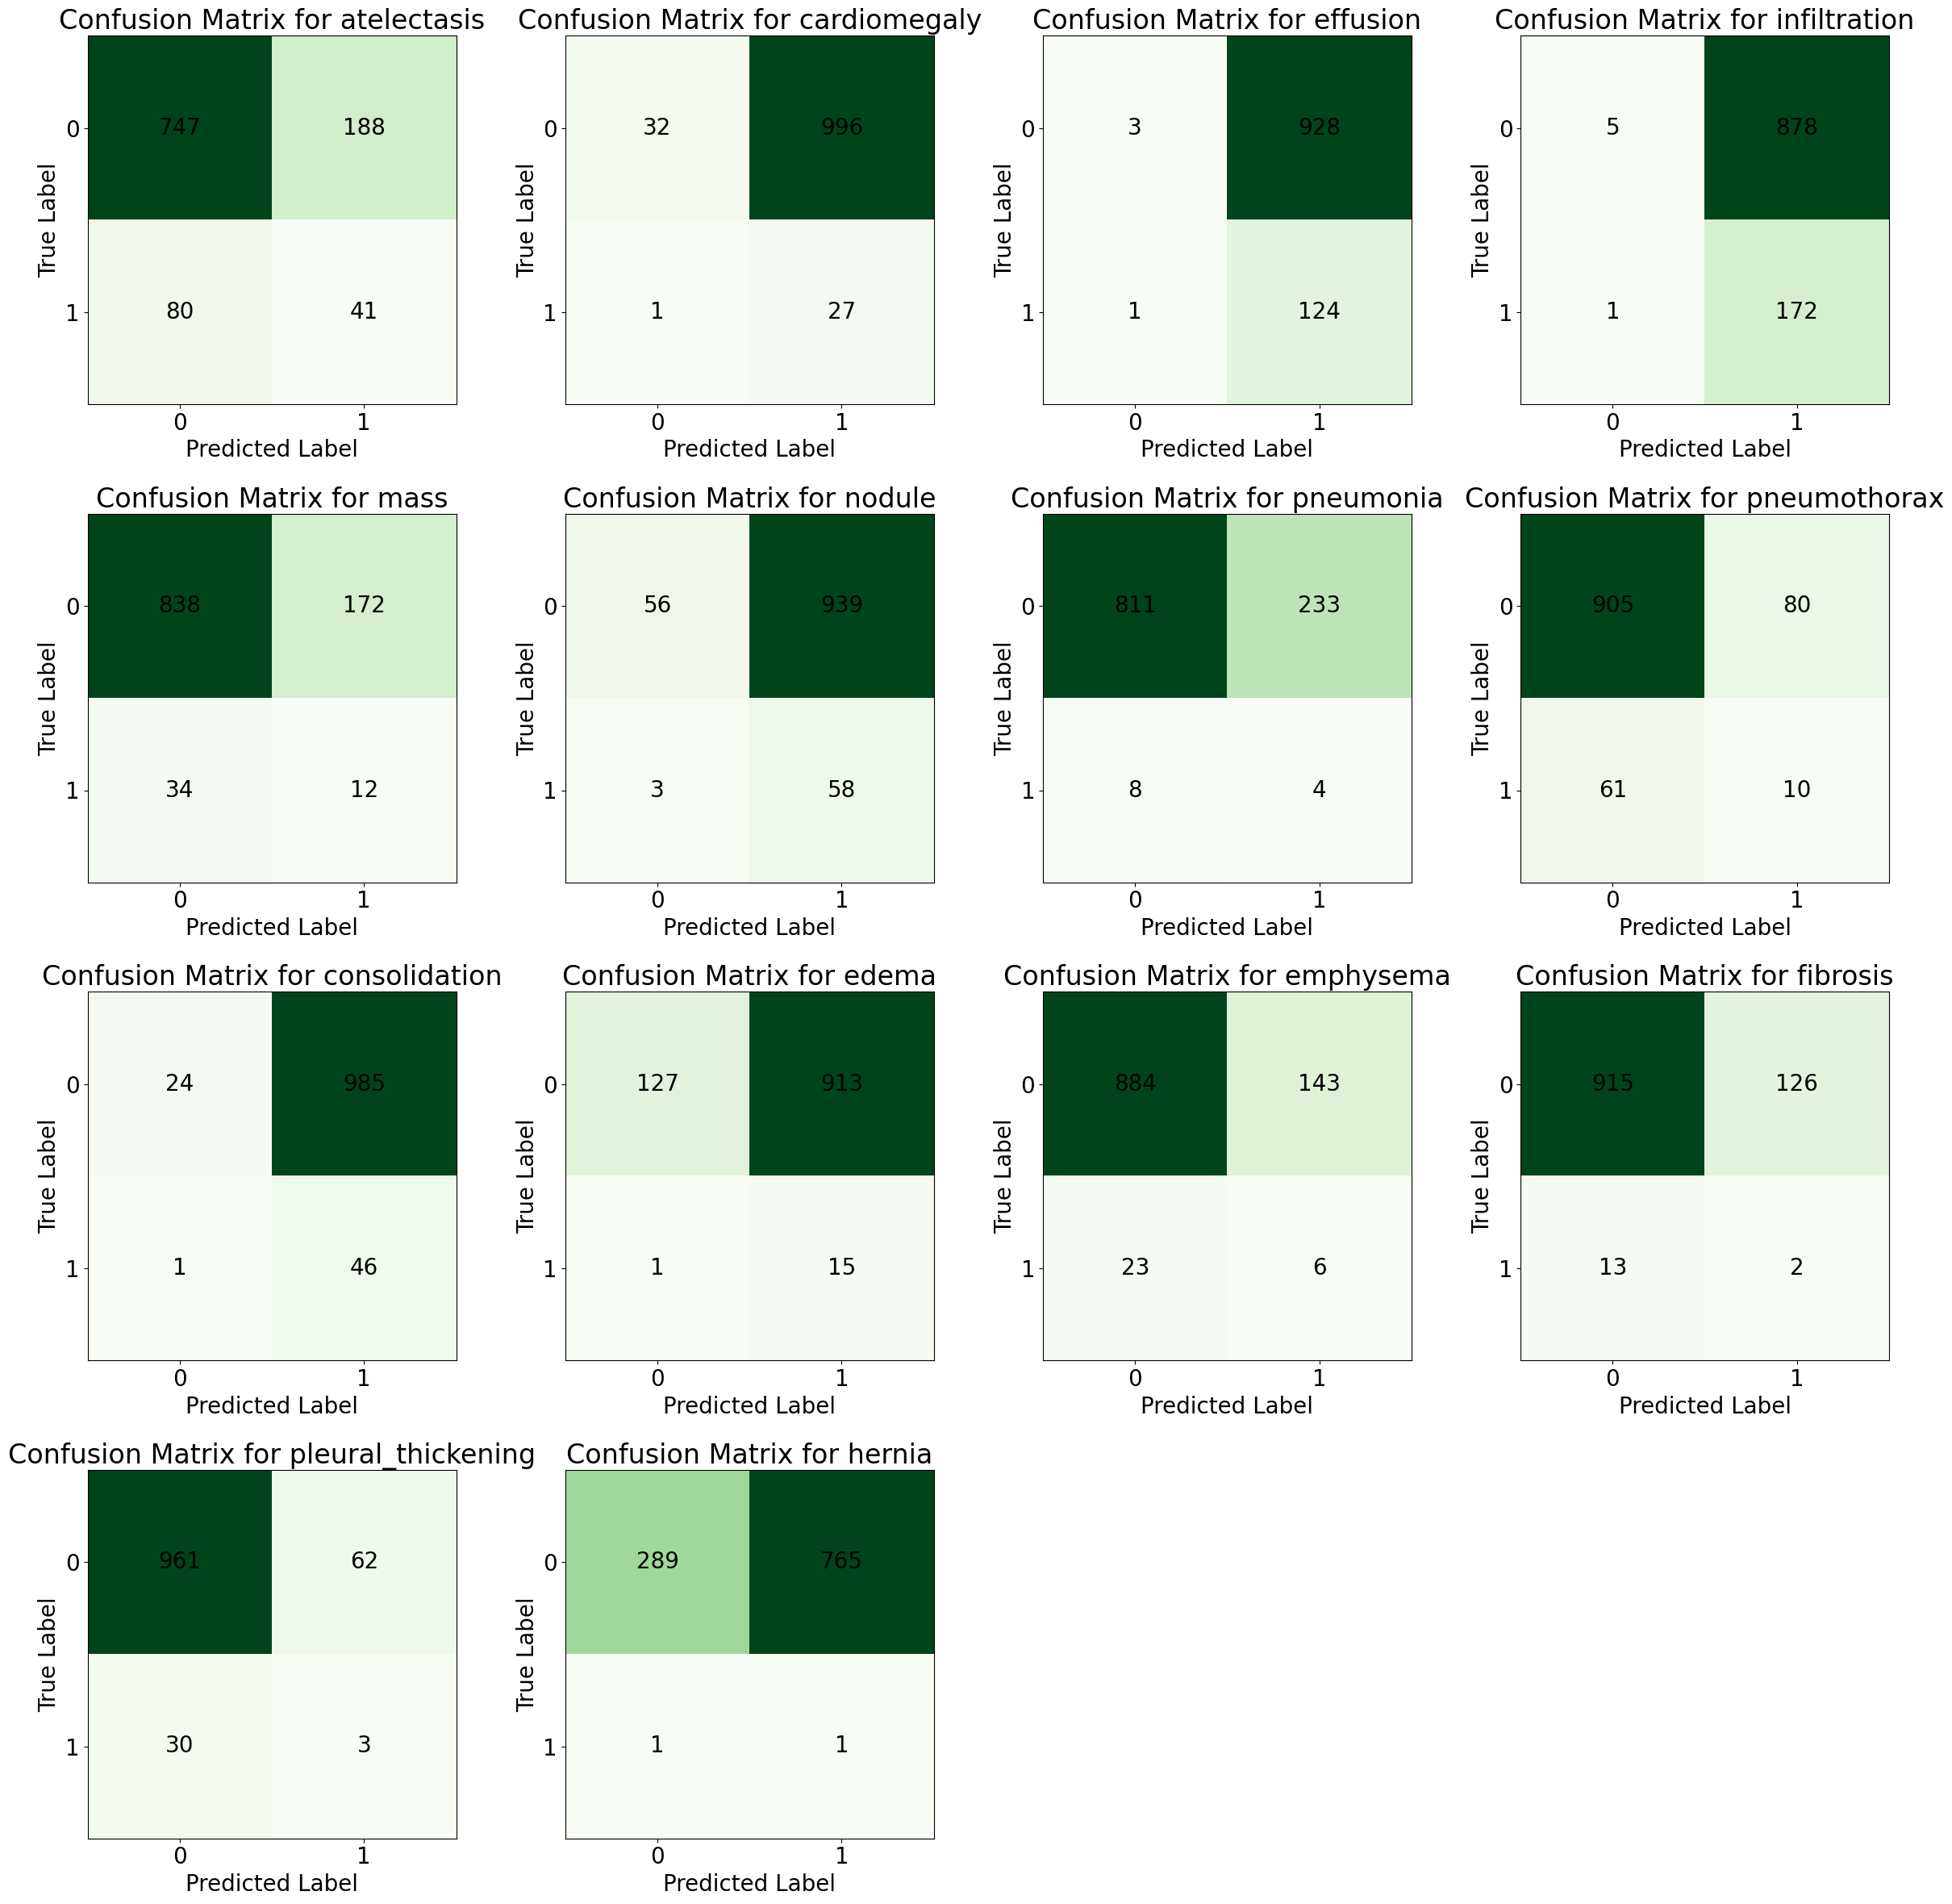

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve

plt.rcParams.update({'font.size': 20})

batch_size=64
steps_per_epoch = len(test_images_64) // batch_size
evaluation = CNN_global_64.evaluate(test_generator_64, steps=steps_per_epoch)

class_labels = [
    'atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass',
    'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema',
    'emphysema', 'fibrosis', 'pleural_thickening', 'hernia'
]

# Print evaluation metrics
print("Test Loss:", evaluation[0])
print("Test AUC:", evaluation[2])
print("Test Binary Accuracy:", evaluation[1])

y_probs = CNN_global_64.predict(test_generator_64, steps=steps_per_epoch)
y_true = test_labels_64

corrected_len = len(y_probs)

# Tune threshold per class using precision-recall curve
optimal_thresholds = []
for i in range(len(class_labels)):
    precision, recall, thresholds = precision_recall_curve(y_true[:corrected_len, i], y_probs[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Avoid divide-by-zero
    optimal_thresholds.append(thresholds[np.argmax(f1_scores)])  # Best F1-score threshold

# Generate predictions using the test generator
y_pred = (y_probs > np.array(optimal_thresholds)).astype(int)

# Print classification report (averaged for multi-label data)
print("Classification Report:\n", classification_report(y_true[:corrected_len], y_pred, target_names=class_labels))  # Pass class_labels as target_names

# Generate confusion matrices for each class (multi-label)
confusion_matrices = multilabel_confusion_matrix(y_true[:corrected_len], y_pred)

# Plot confusion matrices for individual classes
fig, axes = plt.subplots(4, 4, figsize=(24, 24))
axes = axes.flatten()

for idx, (cm, label) in enumerate(zip(confusion_matrices, class_labels)):
    ax = axes[idx]
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    ax.set_title(f"Confusion Matrix for {label}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    tick_marks = [0, 1]
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    # Add values to the confusion matrix
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

# Remove unused subplots
for idx in range(len(class_labels), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
"""
ResNet-50 (CVPR-2016) re-implemented in Keras
– adapted for ChestMNIST-224 (14-label multi-label classification)
Author: <your-name>
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


# --------------------------------------------------------------------------- #
# Low-level bottleneck building blocks
# --------------------------------------------------------------------------- #
def _identity_block(x, filters, wd):
    """Identity bottleneck (no down-sampling)."""
    f1, f2, f3 = filters           # 1×1, 3×3, 1×1 channels
    shortcut = x

    # 1×1 (reduce)
    x = layers.Conv2D(f1, 1, use_bias=False, kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # 3×3
    x = layers.Conv2D(f2, 3, padding="same",
                      use_bias=False, kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # 1×1 (expand)
    x = layers.Conv2D(f3, 1, use_bias=False, kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x


def _conv_block(x, filters, stride, wd):
    """Bottleneck that *does* down-sample (stride > 1)."""
    f1, f2, f3 = filters
    shortcut = x

    # 1×1 (reduce)   – stride 2 if we down-sample
    x = layers.Conv2D(f1, 1, strides=stride, use_bias=False,
                      kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # 3×3
    x = layers.Conv2D(f2, 3, padding="same", use_bias=False,
                      kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # 1×1 (expand)
    x = layers.Conv2D(f3, 1, use_bias=False, kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)

    # Projection shortcut to match dims
    shortcut = layers.Conv2D(f3, 1, strides=stride, use_bias=False,
                             kernel_regularizer=wd)(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x


# --------------------------------------------------------------------------- #
# ResNet-50 factory
# --------------------------------------------------------------------------- #
def build_resnet50(input_shape=(224, 224, 1),
                   num_classes=14,
                   l2_weight=1e-4,
                   dropout_rate=0.5,
                   freeze_until=None   # "conv3", "conv4", etc. or None
                   ) -> keras.Model:
    """
    Full ResNet-50 (3-4-6-3 bottlenecks) with sigmoid head.

    freeze_until : str or None
        If "conv2", "conv3", "conv4" → layers in earlier stages are frozen
        (lr_mult = 0).  Handy when you have only 10 % of the data.
    """
    wd = regularizers.l2(l2_weight)
    inputs = keras.Input(shape=input_shape, name="image")
    x = layers.Rescaling(1./255)(inputs)           # [0,1] grayscale

    # ----------------------------------------------------------------  stem
    x = layers.ZeroPadding2D(3)(x)
    x = layers.Conv2D(64, 7, strides=2,
                      use_bias=False, kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # ----------------------------------------------------------------  conv2_x  (3 blocks)
    x = _conv_block(x, [64, 64, 256], stride=1, wd=wd)     # 256-d output
    for _ in range(2):
        x = _identity_block(x, [64, 64, 256], wd)

    # ----------------------------------------------------------------  conv3_x  (4 blocks)
    if freeze_until == "conv2":  # mark previous layers frozen
        for l in x._keras_history.layer._inbound_nodes[0].graph._nodes_by_depth[0]:
            l.trainable = False
    x = _conv_block(x, [128, 128, 512], stride=2, wd=wd)   # down-sample
    for _ in range(3):
        x = _identity_block(x, [128, 128, 512], wd)

    # ----------------------------------------------------------------  conv4_x  (6 blocks)
    if freeze_until == "conv3":
        for l in x._keras_history.layer._inbound_nodes[0].graph._nodes_by_depth[0]:
            l.trainable = False
    x = _conv_block(x, [256, 256, 1024], stride=2, wd=wd)
    for _ in range(5):
        x = _identity_block(x, [256, 256, 1024], wd)

    # ----------------------------------------------------------------  conv5_x  (3 blocks)
    if freeze_until == "conv4":
        for l in x._keras_history.layer._inbound_nodes[0].graph._nodes_by_depth[0]:
            l.trainable = False
    x = _conv_block(x, [512, 512, 2048], stride=2, wd=wd)
    for _ in range(2):
        x = _identity_block(x, [512, 512, 2048], wd)

    # ----------------------------------------------------------------  classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="sigmoid",
                           kernel_regularizer=wd)(x)

    return keras.Model(inputs, outputs, name="ResNet50")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# ────────────────────────────────────────────────────────────────────────────────
#  RESNET-50  ▸ functional implementation (3-4-6-3 bottleneck configuration)
# ────────────────────────────────────────────────────────────────────────────────
def build_resnet50(
        input_shape=(224, 224, 1),
        num_classes=14,
        weight_decay=1e-4,
        mixed_precision=True,
):
    """
    Return a compiled tf.keras Model implementing ResNet-50 from scratch.
    • input_shape  : (H, W, C) - set C=1 for ChestMNIST.
    • num_classes  : 14 thoracic pathologies.
    • weight_decay : L2 applied to all Conv/FC kernels.
    • mixed_precision : if True → enable float16 on supported GPUs.
    """

    # -------------------- optional mixed-precision -----------------------------
    if mixed_precision:
        from tensorflow.keras import mixed_precision as mp
        mp.set_global_policy("mixed_float16")          # saves ~40 % VRAM

    l2 = regularizers.l2(weight_decay)

    # --------------------------------------------------------------------------
    #  BUILDING BLOCKS
    # --------------------------------------------------------------------------
    def conv_bn_relu(x, filters, k, s=1, name=None):
        x = layers.Conv2D(filters, k, s, padding='same',
                          use_bias=False, kernel_regularizer=l2,
                          kernel_initializer='he_normal',
                          name=None if name is None else name + "_conv")(x)
        x = layers.BatchNormalization(name=None if name is None else name + "_bn")(x)
        return layers.ReLU(name=None if name is None else name + "_relu")(x)

    def bottleneck(x, filters, stride, name):
        """Bottleneck block with identity / conv shortcut."""
        shortcut = x
        # 1×1
        x = conv_bn_relu(x, filters, 1, name=name + "_1")
        # 3×3
        x = conv_bn_relu(x, filters, 3, s=stride, name=name + "_2")
        # 1×1
        x = layers.Conv2D(filters * 4, 1, use_bias=False,
                          kernel_regularizer=l2,
                          kernel_initializer='he_normal',
                          name=name + "_3_conv")(x)
        x = layers.BatchNormalization(name=name + "_3_bn")(x)

        # ----- shortcut path -----
        if stride != 1 or shortcut.shape[-1] != filters * 4:
            shortcut = layers.Conv2D(filters * 4, 1, stride,
                                     use_bias=False, kernel_regularizer=l2,
                                     kernel_initializer='he_normal',
                                     name=name + "_0_conv")(shortcut)
            shortcut = layers.BatchNormalization(name=name + "_0_bn")(shortcut)

        x = layers.Add(name=name + "_add")([x, shortcut])
        return layers.ReLU(name=name + "_out")(x)

    def make_stage(x, filters, n_blocks, stride, name):
        """Build one of the 4 ResNet stages."""
        # first block may downsample
        x = bottleneck(x, filters, stride, name=f"{name}_block1")
        for i in range(2, n_blocks + 1):
            x = bottleneck(x, filters, 1, name=f"{name}_block{i}")
        return x

    # --------------------------------------------------------------------------
    #  STEM
    # --------------------------------------------------------------------------
    inputs = layers.Input(shape=input_shape)
    x = conv_bn_relu(inputs, 64, 7, s=2, name="conv1")
    x = layers.MaxPool2D(3, 2, padding='same', name="pool1")(x)

    # --------------------------------------------------------------------------
    #  4 STAGES:   3 – 4 – 6 – 3 bottleneck blocks
    # --------------------------------------------------------------------------
    x = make_stage(x,  64, 3, stride=1, name="conv2")
    x = make_stage(x, 128, 4, stride=2, name="conv3")
    x = make_stage(x, 256, 6, stride=2, name="conv4")
    x = make_stage(x, 512, 3, stride=2, name="conv5")

    # --------------------------------------------------------------------------
    #  HEAD
    # --------------------------------------------------------------------------
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Dense(
        num_classes,
        kernel_regularizer=l2,
        name="logits")(x)

    # For mixed precision we must cast back to float32 before the sigmoid,
    # otherwise the loss may underflow.
    x = layers.Activation('sigmoid', dtype='float32', name='predictions')(x)

    model = models.Model(inputs, x, name="ResNet50_scratch")

    # NOTE: Compile happens *outside* so you can pass custom losses/metrics
    return model
